# NLP Coursework

# Packages Installment & Setup

In [ ]:
# For HuggingFace Models
!pip install -q transformers sentencepiece

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import string
import subprocess
import transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm

from collections import Counter
from nltk.corpus import stopwords, wordnet
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from urllib import request

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Loading

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def load_data_remote(working_dir_name):
    os.chdir("/")
    
    # Create & Switch to the working directory:
    working_dir = f"/content/drive/MyDrive/{working_dir_name}"
    if not os.path.exists(working_dir):
        os.makedirs(working_dir)
    os.chdir(working_dir)
    
    train_data_url = "https://raw.githubusercontent.com/iz0825/NLP-CW/main/train_set.csv"
    print(f"Fetching {train_data_url}")
    train_df = pd.read_csv(train_data_url)
    train_df = train_df.dropna()
    train_df.drop(train_df[train_df.text == ""].index, inplace=True)
    print(f"Train set loaded. Size = {len(train_df)}")

    dev_data_url = "https://raw.githubusercontent.com/iz0825/NLP-CW/main/dev_set.csv"
    print(f"Fetching {dev_data_url}")
    dev_df = pd.read_csv(dev_data_url)
    dev_df = dev_df.dropna()
    dev_df.drop(dev_df[dev_df.text == ""].index, inplace=True)
    print(f"Dev set loaded. Size = {len(dev_df)}")
    return train_df, dev_df


In [ ]:
def load_data_local(working_dir_name):
    os.chdir("/")

    # Find tsv file:
    bashCommand = ["find", r"/content/drive/MyDrive/", "-name", "dontpatronizeme_pcl.tsv"]
    process = subprocess.Popen(bashCommand, stdout=subprocess.PIPE)
    output, error = process.communicate()
    output = str(output, "utf-8")

    bashCommand = ["dirname", output]
    process = subprocess.Popen(bashCommand, stdout=subprocess.PIPE)
    output, error = process.communicate()
    data_dir = str(output, "utf-8").rstrip("\r\n")

    # Establish working directory in the same folder as the tsv data file:
    working_dir = f"{data_dir}/{working_dir_name}"
    if not os.path.exists(working_dir):
        print(data_dir)
        os.mkdir(working_dir)

    # Fetch data loader:
    os.chdir(data_dir)
    module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
    module_name = module_url.split("/")[-1]
    print(f"Fetching {module_url}")
    with request.urlopen(module_url) as f, open(module_name,"w") as outf:
      a = f.read()
      outf.write(a.decode("utf-8"))

    from dont_patronize_me import DontPatronizeMe

    dpm = DontPatronizeMe(".", "./dontpatronizeme_pcl.tsv")
    # This method loads the subtask 1 data:
    dpm.load_task1()
    # We can then access it as a dataframe:
    dpm_data = dpm.train_task1_df
    dpm_data = dpm_data.dropna()
    # During data analysis, there is empty string present in validation set
    # Drop all rows with text is empty string
    dpm_data.drop(dpm_data[dpm_data.text == ""].index, inplace=True)

    # Switch to the working directory:
    os.chdir(working_dir)

    url_train = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv"
    print(f"Fetching {url_train}")
    train_ids = pd.read_csv(url_train)
    url_val = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv"
    print(f"Fetching {url_val}")
    val_ids = pd.read_csv(url_val)

    train_ids.par_id = train_ids.par_id.astype(str)
    val_ids.par_id = val_ids.par_id.astype(str)

    # Select all columns:
    train_df = dpm_data.loc[dpm_data["par_id"].isin(train_ids.loc[:, "par_id"])]
    print(f"Train set loaded. Size = {len(train_df)}")
    dev_df = dpm_data.loc[dpm_data["par_id"].isin(val_ids.loc[:, "par_id"])]
    print(f"Dev set loaded. Size = {len(dev_df)}")

    return train_df, dev_df


In [ ]:
# Data load remotely or locally:
USE_REMOTE_DATA = True
train_df = pd.DataFrame()
dev_df = pd.DataFrame()

# Current directory in "NLP_CW" after loading data:
if USE_REMOTE_DATA:
    train_df, dev_df = load_data_remote("NLP_CW/")
else:
    train_df, dev_df = load_data_local("NLP_CW/")

Fetching https://raw.githubusercontent.com/iz0825/NLP-CW/main/train_set.csv
Train set loaded. Size = 8375
Fetching https://raw.githubusercontent.com/iz0825/NLP-CW/main/dev_set.csv
Dev set loaded. Size = 2093


# Basic Preprocessing

In [ ]:
def basic_preprocess_fn(text):
    text = re.sub(" +", " ", text).strip()
    if text[0] == "\"" and text[-1] == "\"":
        text = text[1:-1]
    text = re.sub("\"+", "\"", text)
    return text

train_df["text_preprocessed"] = train_df["text"].apply(basic_preprocess_fn)
dev_df["text_preprocessed"] = dev_df["text"].apply(basic_preprocess_fn)

all_df = pd.concat([train_df, dev_df], ignore_index=True)
all_df.head(10)

,par_id,art_id,keyword,country,text,label,orig_label,text_preprocessed
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0,"We 're living in times of absolute insanity , ..."
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0,"In Libya today , there are countless number of..."
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0,White House press secretary Sean Spicer said t...
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0,Council customers only signs would be displaye...
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0,""" Just like we received migrants fleeing El Sa..."
5,6,@@9382277,in-need,in,"To bring down high blood sugar levels , insuli...",0,0,"To bring down high blood sugar levels , insuli..."
6,7,@@7562079,refugee,za,The European Union is making an historic mista...,0,0,The European Union is making an historic mista...
7,8,@@23663488,hopeless,nz,""""""" They 're either hopeless for being beaten ...",0,0,""" They 're either hopeless for being beaten by..."
8,9,@@3449225,homeless,ph,"NUEVA ERA , Ilocos Norte - No family shall be ...",0,1,"NUEVA ERA , Ilocos Norte - No family shall be ..."
9,10,@@2485090,in-need,nz,His spokesman said the Kremlin needed more inf...,0,0,His spokesman said the Kremlin needed more inf...


# Data Analysis

For a written description of the training data. This should include:
1. 5 marks – Analysis of the class labels: how frequent these are and how they correlate with any feature of the data, e.g. input length.
2. 10 marks - Qualitative assessment of the dataset, considering either how hard or how subjective the task is, providing examples in your report.

## Class Labels

In [ ]:
train_pos = train_df[train_df["label"] == 1]
train_neg = train_df[train_df["label"] == 0]
dev_pos = dev_df[dev_df["label"] == 1]
dev_neg = dev_df[dev_df["label"] == 0]
all_pos = all_df[all_df["label"] == 1]
all_neg = all_df[all_df["label"] == 0]
print("---Number of Positive / Negative Samples---")
print(f"Train set: {len(train_pos)} / {len(train_neg)}, {len(train_pos) / len(train_neg)}")
print(f"Dev set: {len(dev_pos)} / {len(dev_neg)}, {len(dev_pos) / len(dev_neg)}")

---Number of Positive / Negative Samples---
Train set: 794 / 7581, 0.1047355230180715
Dev set: 199 / 1894, 0.10506863780359028


In [ ]:
def get_distribution_by_text_length(df):
    bins = [0, 50, 100, 150, 200, 1000]
    cuts = pd.cut(df.text_preprocessed.str.split().apply(len), bins)
    lengths = df.groupby(cuts).size()
    return lengths

def get_distribution_by_column(df, column):
    lengths = df.groupby(column).size()
    return lengths

def plot_label_distribution(train, dev, all, xlabel, ylabel, title):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), dpi=80)
    train.plot(y=["pos", "neg"], kind="bar", ax=axes[0], legend=0)
    dev.plot(y=["pos", "neg"], kind="bar", ax=axes[1], legend=0)
    all.plot(y=["pos", "neg"], kind="bar", ax=axes[2])

    axes[0].set_title("Train")
    axes[1].set_title("Dev")
    axes[2].set_title("Combined")
    for ax in axes:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

    ax.legend(bbox_to_anchor=(1.25, 1))
    plt.suptitle(title)
    plt.show()

def plot_label_distribution_single(df, xlabel, ylabel, title, adjust_legend=False):
    fig, ax = plt.subplots(figsize=(8, 4), dpi=80)
    df.plot(y=["pos", "neg"], kind="bar", ax=ax)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if adjust_legend:
        plt.legend(bbox_to_anchor=(1.15, 1))
    plt.show()


Distribution of Labels VS Preprocessed Text Lengths - All Data:



,pos,neg,ratio
text_preprocessed,,,
"(0, 50]",547,6175,0.088583
"(50, 100]",370,2830,0.130742
"(100, 150]",69,410,0.168293
"(150, 200]",4,52,0.076923
"(200, 1000]",3,8,0.375000



Distribution of Labels VS Preprocessed Text Lengths - Training Data:



,pos,neg,ratio
text_preprocessed,,,
"(0, 50]",439,4921,0.089210
"(50, 100]",292,2277,0.128239
"(100, 150]",58,333,0.174174
"(150, 200]",2,43,0.046512
"(200, 1000]",3,7,0.428571



Distribution of Labels VS Preprocessed Text Lengths - Dev Data:



,pos,neg,ratio
text_preprocessed,,,
"(0, 50]",108,1254,0.086124
"(50, 100]",78,553,0.141049
"(100, 150]",11,77,0.142857
"(150, 200]",2,9,0.222222
"(200, 1000]",0,1,0.000000


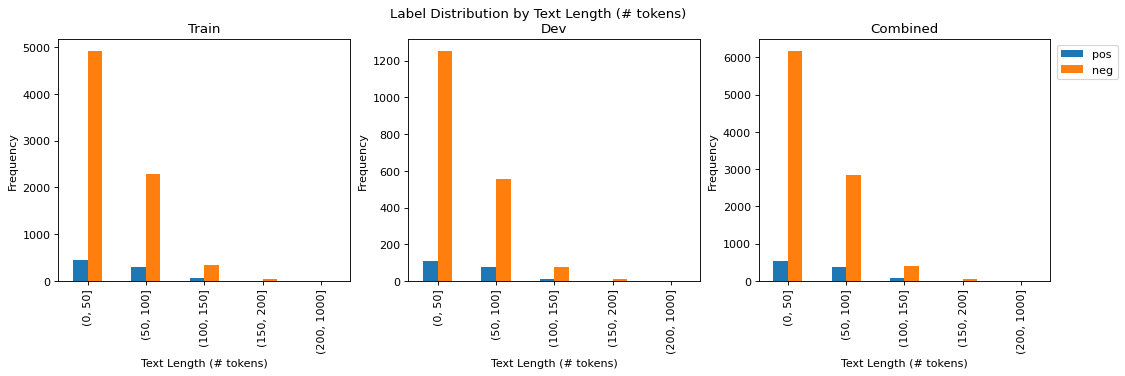

In [ ]:
def display_stats_textlengths():
    all_lengths_pos = get_distribution_by_text_length(all_pos).rename("pos")
    all_lengths_neg = get_distribution_by_text_length(all_neg).rename("neg")
    all_lengths_ratio = all_lengths_pos.div(all_lengths_neg).rename("ratio") 
    all_lengths = pd.concat([all_lengths_pos, all_lengths_neg, all_lengths_ratio], axis=1)

    train_lengths_pos = get_distribution_by_text_length(train_pos).rename("pos")
    train_lengths_neg = get_distribution_by_text_length(train_neg).rename("neg")
    train_lengths_ratio = train_lengths_pos.div(train_lengths_neg).rename("ratio") 
    train_lengths = pd.concat([train_lengths_pos, train_lengths_neg, train_lengths_ratio], axis=1)

    dev_lengths_pos = get_distribution_by_text_length(dev_pos).rename("pos")
    dev_lengths_neg = get_distribution_by_text_length(dev_neg).rename("neg")
    dev_lengths_ratio = dev_lengths_pos.div(dev_lengths_neg).rename("ratio") 
    dev_lengths = pd.concat([dev_lengths_pos, dev_lengths_neg, dev_lengths_ratio], axis=1)

    print("Distribution of Labels VS Preprocessed Text Lengths - All Data:\n")
    display(all_lengths)
    print("\nDistribution of Labels VS Preprocessed Text Lengths - Training Data:\n")
    display(train_lengths)
    print("\nDistribution of Labels VS Preprocessed Text Lengths - Dev Data:\n")
    display(dev_lengths)
    print("\n")

    plot_label_distribution(train_lengths,
                            dev_lengths,
                            all_lengths,
                            "Text Length (# tokens)",
                            "Frequency",
                            "Label Distribution by Text Length (# tokens)")

display_stats_textlengths()

Distribution of Labels VS Country Code - All Data:



,pos,neg,ratio
country,,,
gh,75,448,0.167411
ng,72,465,0.154839
ph,67,478,0.140167
jm,57,433,0.131640
za,58,491,0.118126
gb,57,483,0.118012
tz,41,374,0.109626
pk,53,492,0.107724
lk,49,455,0.107692



Distribution of Labels VS Country Code - Training Data:



,pos,neg,ratio
country,,,
gh,63,376,0.167553
ng,57,372,0.153226
jm,47,339,0.138643
ph,52,388,0.134021
gb,48,365,0.131507
za,47,392,0.119898
ie,42,383,0.109661
lk,40,379,0.105541
tz,30,291,0.103093



Distribution of Labels VS Country Code - Dev Data:



,pos,neg,ratio
country,,,
gh,12,72,0.166667
ph,15,90,0.166667
ng,15,93,0.161290
pk,14,95,0.147368
nz,12,89,0.134831
tz,11,83,0.132530
ke,13,100,0.130000
lk,9,76,0.118421
za,11,99,0.111111


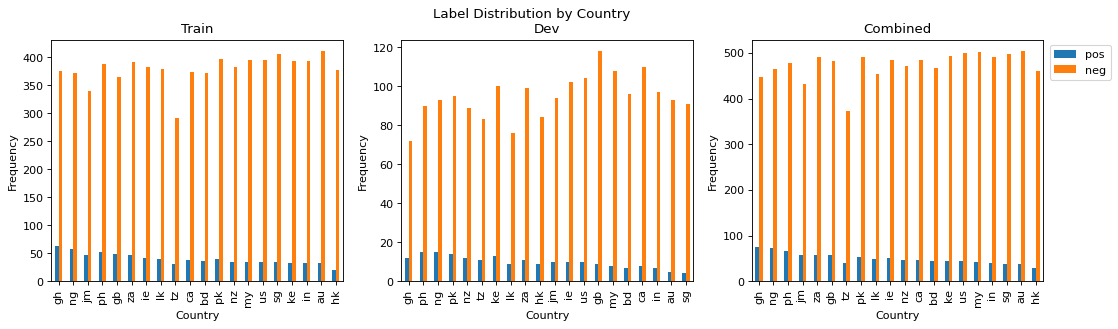

In [ ]:
def display_stats_country():
    all_country_pos = get_distribution_by_column(all_pos, "country").rename("pos")
    all_country_neg = get_distribution_by_column(all_neg, "country").rename("neg")
    all_country_ratio = all_country_pos.div(all_country_neg).rename("ratio") 
    all_country = pd.concat([all_country_pos, all_country_neg, all_country_ratio], axis=1)
    all_country = all_country.sort_values("ratio", ascending=False)

    train_country_pos = get_distribution_by_column(train_pos, 'country').rename('pos')
    train_country_neg = get_distribution_by_column(train_neg, 'country').rename('neg')
    train_country_ratio = train_country_pos.div(train_country_neg).rename("ratio") 
    train_country = pd.concat([train_country_pos, train_country_neg, train_country_ratio], axis=1)
    train_country = train_country.sort_values("ratio", ascending=False)

    dev_country_pos = get_distribution_by_column(dev_pos, 'country').rename('pos')
    dev_country_neg = get_distribution_by_column(dev_neg, 'country').rename('neg')
    dev_country_ratio = dev_country_pos.div(dev_country_neg).rename("ratio") 
    dev_country = pd.concat([dev_country_pos, dev_country_neg, dev_country_ratio], axis=1)
    dev_country = dev_country.sort_values("ratio", ascending=False)

    print("Distribution of Labels VS Country Code - All Data:\n")
    display(all_country)
    print("\nDistribution of Labels VS Country Code - Training Data:\n")
    display(train_country)
    print("\nDistribution of Labels VS Country Code - Dev Data:\n")
    display(dev_country)
    print("\n")

    plot_label_distribution(train_country,
                            dev_country,
                            all_country,
                            "Country",
                            "Frequency",
                            "Label Distribution by Country")

display_stats_country()

Distribution of Labels VS Keyword - All Data:



,pos,neg,ratio
keyword,,,
homeless,178,899,0.197998
poor-families,150,759,0.197628
in-need,176,906,0.194260
hopeless,124,881,0.140749
refugee,86,982,0.087576
disabled,81,947,0.085533
vulnerable,80,1000,0.080000
women,52,1018,0.051081
migrant,36,1052,0.034221



Distribution of Labels VS Keyword - Training Data:



,pos,neg,ratio
keyword,,,
homeless,149,716,0.208101
in-need,143,713,0.200561
poor-families,112,607,0.184514
hopeless,98,690,0.142029
refugee,73,807,0.090458
disabled,67,767,0.087353
vulnerable,60,811,0.073983
women,38,799,0.047559
migrant,31,851,0.036428



Distribution of Labels VS Keyword - Dev Data:



,pos,neg,ratio
keyword,,,
poor-families,38,152,0.250000
in-need,33,193,0.170984
homeless,29,183,0.158470
hopeless,26,191,0.136126
vulnerable,20,189,0.105820
disabled,14,180,0.077778
refugee,13,175,0.074286
women,14,219,0.063927
immigrant,7,211,0.033175


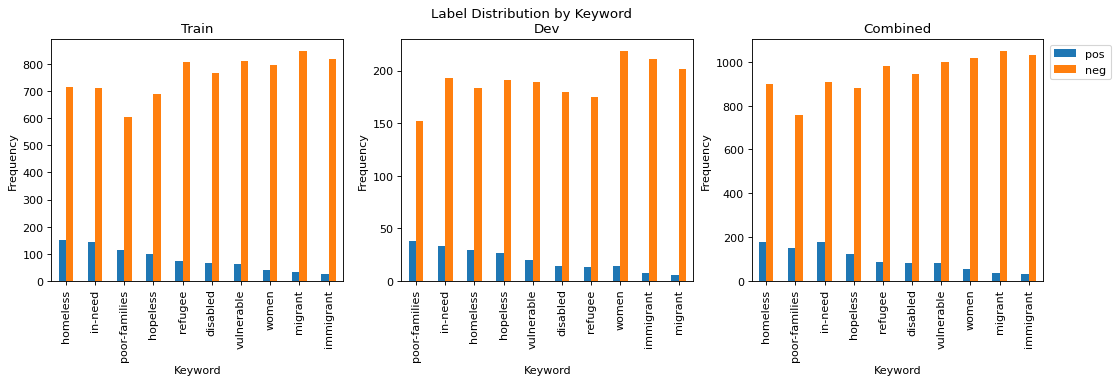

In [ ]:
def display_stats_keyword():
    all_keyword_pos = get_distribution_by_column(all_pos, "keyword").rename("pos")
    all_keyword_neg = get_distribution_by_column(all_neg, "keyword").rename("neg")
    all_keyword_ratio = all_keyword_pos.div(all_keyword_neg).rename("ratio") 
    all_keyword = pd.concat([all_keyword_pos, all_keyword_neg, all_keyword_ratio], axis=1)
    all_keyword = all_keyword.sort_values("ratio", ascending=False)


    train_keyword_pos = get_distribution_by_column(train_pos, "keyword").rename("pos")
    train_keyword_neg = get_distribution_by_column(train_neg, "keyword").rename("neg")
    train_keyword_ratio = train_keyword_pos.div(train_keyword_neg).rename("ratio") 
    train_keyword = pd.concat([train_keyword_pos, train_keyword_neg, train_keyword_ratio], axis=1)
    train_keyword = train_keyword.sort_values("ratio", ascending=False)

    dev_keyword_pos = get_distribution_by_column(dev_pos, "keyword").rename("pos")
    dev_keyword_neg = get_distribution_by_column(dev_neg, "keyword").rename("neg")
    dev_keyword_ratio = dev_keyword_pos.div(dev_keyword_neg).rename("ratio") 
    dev_keyword = pd.concat([dev_keyword_pos, dev_keyword_neg, dev_keyword_ratio], axis=1)
    dev_keyword = dev_keyword.sort_values("ratio", ascending=False)

    print("Distribution of Labels VS Keyword - All Data:\n")
    display(all_keyword)
    print("\nDistribution of Labels VS Keyword - Training Data:\n")
    display(train_keyword)
    print("\nDistribution of Labels VS Keyword - Dev Data:\n")
    display(dev_keyword)
    print("\n")
    plot_label_distribution(train_keyword,
                            dev_keyword,
                            all_keyword,"Keyword",
                            "Frequency",
                            "Label Distribution by Keyword")
  
display_stats_keyword()

## Training data

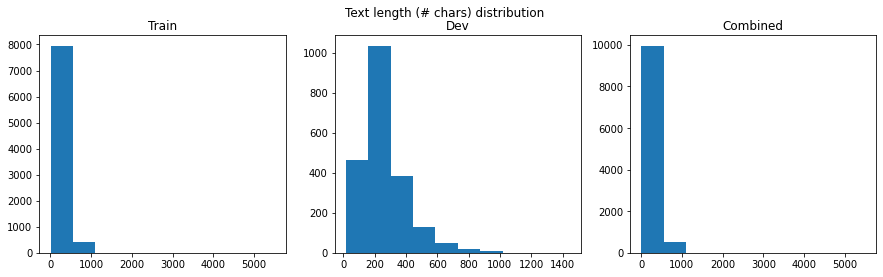

Max text length in training set: 5493
Max text length in dev set: 1446


In [ ]:
def display_lengths_char():
    train_char_lens = [len(text) for text in train_df["text_preprocessed"]]
    dev_char_lens = [len(text) for text in dev_df["text_preprocessed"]]
    all_char_lens = [len(text) for text in all_df["text_preprocessed"]]

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    axs[0].hist(train_char_lens)
    axs[0].set_title("Train")
    axs[1].hist(dev_char_lens)
    axs[1].set_title("Dev")
    axs[2].hist(all_char_lens)
    axs[2].set_title("Combined")
    plt.suptitle("Text length (# chars) distribution")
    plt.show()

    print(f"Max text length in training set: {np.max(train_char_lens)}")
    print(f"Max text length in dev set: {np.max(dev_char_lens)}")

display_lengths_char()

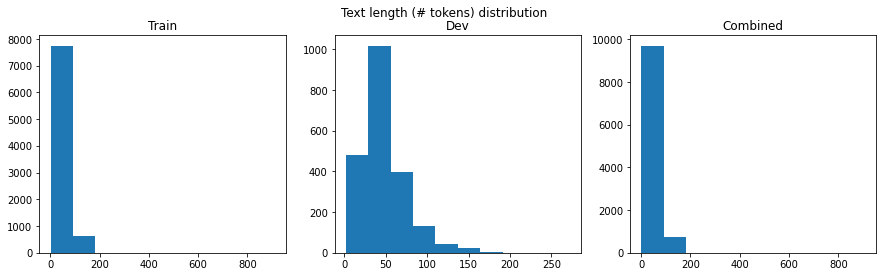

Max text length in training set: 909
Max text length in dev set: 272


In [ ]:
def display_lengths_vocab():
    train_word_lens = [len(text.split()) for text in train_df["text_preprocessed"]]
    dev_word_lens = [len(text.split()) for text in dev_df["text_preprocessed"]]
    all_word_lens = [len(text.split()) for text in all_df["text_preprocessed"]]

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    axs[0].hist(train_word_lens)
    axs[0].set_title("Train")
    axs[1].hist(dev_word_lens)
    axs[1].set_title("Dev")
    axs[2].hist(all_word_lens)
    axs[2].set_title("Combined")
    plt.suptitle("Text length (# tokens) distribution")
    plt.show()

    print(f"Max text length in training set: {np.max(train_word_lens)}")
    print(f"Max text length in dev set: {np.max(dev_word_lens)}")

display_lengths_vocab()

In [ ]:
def get_vocab(df):
    vocab = set()
    for text in df["text_preprocessed"]:
        vocab.update(text.split())
    return vocab

def display_stats_sizes():
    train_vocab = get_vocab(train_df)
    dev_vocab = get_vocab(dev_df)
    all_vocab = get_vocab(all_df)

    print(f"Vocabulary size of train set: {len(train_vocab)}")
    print(f"Vocabulary size of val set: {len(dev_vocab)}")
    print(f"Vocabulary size of combined set: {len(all_vocab)}")
    print(f"Number of words in val but not in train: {len(dev_vocab.difference(train_vocab))}")
    print(f"Number of words in train but not in val: {len(train_vocab.difference(dev_vocab))}")

display_stats_sizes()

Vocabulary size of train set: 33099
Vocabulary size of val set: 14523
Vocabulary size of combined set: 37411
Number of words in val but not in train: 4312
Number of words in train but not in val: 22888


# Data Augmentation:

## Synonym Replacement:

In [ ]:
def get_synonyms(word):
    # Return synonyms of a word:
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def synonym_replacement(words, n=1):
    # Remove stop words:
    stop_words = []
    for w in stopwords.words('english'):
        stop_words.append(w)
    words = words.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    # Replace n word with random synonym:
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    sentence = ' '.join(new_words)

    return sentence

def syn_aug(train_df, num=1):
    # Dataframe operations:
    new_train_df = train_df.copy(deep=True)
    for index, row in new_train_df.iterrows():
        if row['orig_label'] > 1:
            for i in range(num):
                new_row = row.copy(deep=True)
                new_row["text_preprocessed"] = synonym_replacement(row["text_preprocessed"])
                
                new_train_df = new_train_df.append(new_row,ignore_index=True)
    return new_train_df

USE_SYN_AUG = False
if USE_SYN_AUG:
    train_df = syn_aug(train_df)
print(len(train_df[train_df["label"] == 1]))
print(len(train_df[train_df["label"] == 0]))

794
7581


## Random Swap:

In [ ]:
def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words) - 1)
    random_idx_2 = random_idx_1
    counter = 0
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words) - 1)
        counter += 1  
        if counter > 3:
            return new_words
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
    return new_words

def random_swap(words, n=1):
    words = words.split()
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
    sentence = ' '.join(new_words)
    return sentence


def swap_aug(train_df, num=1):
    # Dataframe operations:
    new_train_df = train_df.copy(deep=True)
    for index, row in new_train_df.iterrows():
        if row['orig_label'] > 1:
            for i in range(num):
                new_row = row.copy(deep=True)
                new_row["text_preprocessed"] = random_swap(row["text_preprocessed"])
                new_train_df = new_train_df.append(new_row,ignore_index=True)
    return new_train_df

USE_SWAP_AUG = False
if (USE_SWAP_AUG):
      train_df = swap_aug(train_df)
print(len(train_df[train_df["label"] == 1]))
print(len(train_df[train_df["label"] == 0]))

794
7581


# Model

In [ ]:
# Set up CUDA:
# Set a random seed to ensure that results are reproducible:
SEED = 0

use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.backends.cudnn.deterministic = True

torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using {device}")

Using cuda


In [ ]:
country_dict = {'gh': 0, 'ph': 1, 'ng': 2, 'pk': 3, 'nz': 4, 'tz': 5, 'ke': 6, 'lk': 7, 'za': 8, 'hk': 9, 'jm': 10, 
                'ie': 11, 'us': 12, 'gb': 13, 'my': 14, 'bd': 15, 'ca': 16, 'in': 17, 'au': 18, 'sg': 19}

keyword_dict = {'poor-families': 0, 'in-need': 1, 'homeless': 2, 'hopeless': 3, 'vulnerable': 4, 'disabled': 5, 'refugee': 6,
                'women': 7, 'immigrant': 8, 'migrant': 9}

def to_one_hot(input, is_country=False):
    if is_country:
        output = [0] * 20
        country_num = country_dict[input]
        output[country_num] = 1
    else:
        output = [0] * 10
        keyword_num = keyword_dict[input]
        output[keyword_num] = 1
    return torch.Tensor(output)

In [ ]:
class DPMDataset(Dataset):
    def __init__(self, df, is_test=False):
        self.df = df
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.df.iloc[index]["text_preprocessed"]

        keyword_one_hot = to_one_hot(self.df.iloc[index]['keyword'])
        country_one_hot = to_one_hot(self.df.iloc[index]['country'], is_country=True)

        if self.is_test:
            return text, keyword_one_hot, country_one_hot

        label = torch.tensor(self.df.iloc[index]["label"], dtype=torch.long)
        return text, keyword_one_hot, country_one_hot, label

In [ ]:
class CustomBERT(nn.Module):
    def __init__(self, model_name="roberta-base", use_categorical=False, dropout_prob=0.2):
        super(CustomBERT, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                                       num_labels=2)
        self.use_categorical = use_categorical

        self.dense = torch.nn.Linear(768, 768)

        self.dropout = torch.nn.Dropout(dropout_prob)

        self.outproj = torch.nn.Linear(768, 2)

        self.mlp = nn.Sequential(
            nn.Linear(798, 798),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob),
            nn.Linear(798, 200),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob),
            nn.Linear(200, 50),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_prob),
            nn.Linear(50, 2),
        )

    def forward(self, input_ids, attention_mask, labels, cat_feats=None):
        # Output shape: batch_size x sequence_length x 768:
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            output_hidden_states=True)

        hidden_states = outputs.hidden_states
        outputs = hidden_states[-1][:, 0, :]    # Get hidden states from last layer.

        if self.use_categorical:
            outputs = self.dropout(outputs)
            combined_feats = torch.cat((outputs, cat_feats), 1)
            outputs = self.mlp(combined_feats)

        else:
            outputs = self.dropout(outputs)

            outputs = self.dense(outputs)
            outputs = torch.tanh(outputs)

            outputs = self.dropout(outputs)
            
            outputs = self.outproj(outputs)

        return outputs

In [ ]:
class CollateSequence:
    def __init__(self, tokenizer, max_len=128, is_test=False):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_test = is_test
    
    def __call__(self, batch):
        texts = [sample[0] for sample in batch]
        tokens = self.tokenizer(texts,
                                return_tensors="pt",
                                padding=True,
                                truncation=True,
                                max_length=self.max_len)
        input_ids, attn_masks = tokens["input_ids"], tokens["attention_mask"]
        keywords = torch.stack([sample[1] for sample in batch])
        countries = torch.stack([sample[2] for sample in batch])

        if self.is_test:
            return input_ids, attn_masks, keywords, countries

        labels = torch.stack([sample[3] for sample in batch])
        return input_ids, attn_masks, labels, keywords, countries

In [ ]:
def get_dataloaders(train_df,
                    dev_df,
                    batch_size,
                    tokenizer,
                    tokenizer_max_len,
                    use_weighted_sampler=True,
                    train_samples_modification=None):

    train_pos = train_df[train_df["label"] == 1]
    train_neg = train_df[train_df["label"] == 0]

    if train_samples_modification == "DOWNSAMPLING":
        train_neg = train_neg.sample(len(train_pos) * 2, random_state=SEED)
        train_df = pd.concat([train_pos, train_neg])

    train_pos = train_df[train_df["label"] == 1]
    train_neg = train_df[train_df["label"] == 0]

    train_dataset = DPMDataset(train_df)
    dev_dataset = DPMDataset(dev_df)

    collate_fn = CollateSequence(tokenizer, tokenizer_max_len)

    if use_weighted_sampler:
        train_class_count = np.array([len(train_neg), len(train_pos)])
        weight = 1. / train_class_count
        samples_weight = np.array([weight[l] for l in train_df.loc[:, 'label']])
        samples_weight = torch.from_numpy(samples_weight)
        sampler = WeightedRandomSampler(samples_weight,
                                        len(samples_weight),
                                        replacement=True)

        train_loader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  collate_fn=collate_fn,
                                  sampler=sampler)
    else:
        train_loader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  collate_fn=collate_fn)

    dev_loader = DataLoader(dev_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            collate_fn=collate_fn)

    return train_loader, dev_loader

In [ ]:
def eval_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            input_ids, attn_mask, labels, keywords, countries = data
            input_ids = input_ids.to(device)
            attn_mask = attn_mask.to(device)
            labels = labels.to(device)
            cat_feats = torch.cat((keywords, countries), 1).to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attn_mask,
                            labels=labels,
                            cat_feats=cat_feats)
            
            predictions = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            all_preds.extend(predictions)

            labels = labels.detach().cpu().numpy()
            all_labels.extend(labels)
            
    acc = balanced_accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels,
                                                               all_preds,
                                                               average=None)

    return acc, precision, recall, f1

In [ ]:
def train_model(model, optimizer, scheduler, train_loader, dev_loader, num_epochs, criterion):

    train_losses = []
    dev_f1s = []

    for epoch in range(num_epochs):
        total_loss = 0
        model.train()

        with tqdm.tqdm(train_loader, unit="batch") as tepoch: 
            for i, data in enumerate(tepoch):   
                input_ids, attn_mask, labels, keywords, countries = data
                input_ids = input_ids.to(device)
                attn_mask = attn_mask.to(device)
                labels = labels.to(device)
                cat_feats = torch.cat((keywords, countries), 1).to(device)
                
                outputs = model(input_ids=input_ids,
                                attention_mask=attn_mask,
                                labels=labels,
                                cat_feats=cat_feats)

                optimizer.zero_grad()
                loss = criterion(outputs, labels)    # Output is logits for each sample.
                loss.backward()

                clip_grad_norm_(model.parameters(), 1)

                optimizer.step()
                scheduler.step()

                total_loss += loss.item()

                tepoch.set_description(f"Epoch {epoch + 1}")
                tepoch.set_postfix(loss=loss.item())
    
        # Evaluate on the dev set:
        dev_acc, dev_precision, dev_recall, dev_f1 = eval_model(model, dev_loader)

        train_losses.append(total_loss)
        dev_f1s.append(dev_f1)

        print(f"Epoch: {epoch + 1}. Loss: {total_loss:.4f}. Dev Acc: {dev_acc:.4f}. Dev Precision {dev_precision}. Dev Recall: {dev_recall}. Dev F1: {dev_f1}.")
    
    return train_losses, dev_f1s

In [ ]:
def run_train(train_df,
              dev_df,
              model,
              tokenizer,
              optimizer,
              batch_size,
              tokenizer_max_len,
              loss_pos_weight=0.5,
              epochs=1,
              train_samples_modification="UPSAMPLING",
              use_categorical=False):
    
    train_loader, dev_loader = get_dataloaders(train_df,
                                               dev_df,
                                               batch_size,
                                               tokenizer, 
                                               tokenizer_max_len,
                                               train_samples_modification=train_samples_modification)
    
    # If wish to weigh classes differently in loss computation:
    weight = torch.tensor([1 - loss_pos_weight, loss_pos_weight])
    criterion = nn.CrossEntropyLoss(weight=weight).to(device)

    num_warmup_steps = 0
    num_training_steps= int(len(train_loader) * epochs)

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=num_warmup_steps,
                                                num_training_steps=num_training_steps)

    train_losses, dev_f1s = train_model(model,
                                        optimizer,
                                        scheduler,
                                        train_loader,
                                        dev_loader,
                                        num_epochs=epochs,
                                        criterion=criterion)
    return train_losses, dev_f1s

In [ ]:
BATCH_SIZE = 32 # fixed due to memory capacity
EPOCHS = 10
EPSILON = 1e-6  # same as HuggingFace default
LEARNING_RATE = 1e-5
MAX_LEN = 128
WEIGHT_DECAY = 0.02
DROPOUT_PROB = 0.2
MODEL_NAME = "microsoft/deberta-v3-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = CustomBERT(MODEL_NAME, use_categorical=False, dropout_prob=DROPOUT_PROB).to(device)
for name, param in model.named_parameters():
    if name.startswith("bert.deberta.embeddings"):
        param.requires_grad = False
optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  eps=EPSILON,
                  weight_decay=WEIGHT_DECAY)
train_losses, dev_f1s = run_train(train_df,
                                  dev_df,
                                  model,
                                  tokenizer,
                                  optimizer,
                                  BATCH_SIZE,
                                  MAX_LEN,
                                  epochs=EPOCHS)
plt.plot(train_losses)
plt.title(f"Train Losses - Deberta Base (v3): lr = {LEARNING_RATE}, Max_Len = {MAX_LEN}")
plt.show()
plt.plot([dev[1] for dev in dev_f1s])
plt.title(f"Positive Dev F1 - Deberta Base (v3): lr = {LEARNING_RATE}, Max_Len = {MAX_LEN}")
plt.show()

In [ ]:
torch.save(model, "./model.pt")

## Ensembling

In [ ]:
def stacked_dataset(df, members):
    stackX = None
    for model in members:
        # Make prediction:
        preds = predict(df,
                        model,
                        tokenizer,
                        BATCH_SIZE,
                        MAX_LEN)
        preds_a = []
        for p in preds:
            for pp in p:
                preds_a.append(pp)
        preds_a = np.array(preds_a)
        # Stack predictions into [rows, members, probabilities]:
        if stackX is None:
            stackX = preds_a
        else:
            stackX = np.dstack((stackX, preds_a))
    # Flatten predictions to [rows, members x probabilities]:
    stackX = np.array(stackX)
    stackX = stackX.reshape((stackX.shape[0], 4))
    return stackX

def predict(df, model, tokenizer, batch_size, tokenizer_max_len):
    test_dataset = DPMDataset(df, is_test=True)
    collate_fn = CollateSequence(tokenizer,
                                 tokenizer_max_len,
                                 is_test=True)
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             collate_fn=collate_fn)
    
    model.eval()
    all_preds = []

    with torch.no_grad():
        for _, data in enumerate(test_loader):
            input_ids, attn_mask, keywords, countries = data
            input_ids = input_ids.to(device)
            attn_mask = attn_mask.to(device)

            cat_feats = torch.cat((keywords, countries), 1).to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attn_mask,
                            cat_feats=cat_feats,
                            labels=None).cpu().numpy()
            
            all_preds.append(outputs)
    
    return all_preds

# Make a prediction with the stacked model:
def stacked_prediction(members, model):
	# Create dataset using ensemble:
	stackedX = stacked_dataset(test_df, members)
	# Make a prediction:
	yhat = model.predict(stackedX)
	return yhat

def simple_ensembling(members):
    stackedX = stacked_dataset(train_df, members)  
    model = LogisticRegression()
    model.fit(stackedX,  train_df["label"].to_numpy())


# Test

In [ ]:
# Function taken from https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py
def load_test_data():
    """
    Load task 1 test set data (text and other categorical columns) 
    It returns a pandas dataframe with the loaded data.
    """
    test_url = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv"
    rows = []
    with request.urlopen(test_url) as f:
        for line in f:
            line = line.decode('utf-8')
            par_id = line.strip().split('\t')[0]
            art_id = line.strip().split('\t')[1]
            keyword = line.strip().split('\t')[2]
            country = line.strip().split('\t')[3]
            text = line.strip().split('\t')[4]
            rows.append({
                'par_id': par_id,
                'art_id': art_id,
                'keyword': keyword,
                'country': country,
                'text': text,
            })
    df = pd.DataFrame(rows, columns=['par_id', 'art_id', 'keyword', 'country', 'text'])
    return df

test_df = load_test_data()
print(f'Number of samples: {len(test_df)}')
test_df["text_preprocessed"] = test_df["text"].apply(basic_preprocess_fn)
test_df.head()

Number of samples: 3832


,par_id,art_id,keyword,country,text,text_preprocessed
0,t_0,@@7258997,vulnerable,us,"In the meantime , conservatives are working to...","In the meantime , conservatives are working to..."
1,t_1,@@16397324,women,pk,In most poor households with no education chil...,In most poor households with no education chil...
2,t_2,@@16257812,migrant,ca,The real question is not whether immigration i...,The real question is not whether immigration i...
3,t_3,@@3509652,migrant,gb,"In total , the country 's immigrant population...","In total , the country 's immigrant population..."
4,t_4,@@477506,vulnerable,ca,"Members of the church , which is part of Ken C...","Members of the church , which is part of Ken C..."


In [ ]:
def test_model(test_df, model, tokenizer, batch_size, tokenizer_max_len, is_test=True):
    test_dataset = DPMDataset(test_df, is_test=is_test)
    collate_fn = CollateSequence(tokenizer, tokenizer_max_len, is_test=is_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             collate_fn=collate_fn)
    
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for _, data in enumerate(test_loader):
            if is_test:
                input_ids, attn_mask, keywords, countries = data
            else:
                input_ids, attn_mask, labels, keywords, countries = data
            input_ids = input_ids.to(device)
            attn_mask = attn_mask.to(device)

            cat_feats = torch.cat((keywords, countries), 1).to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attn_mask,
                            cat_feats=cat_feats,
                            labels=None)
            
            predictions = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            all_preds.extend(predictions)
            if not is_test:
                all_labels.extend(labels)
    
    if is_test:
        return all_preds
    else:
        return all_preds, all_labels

# Helper function to save predictions to an output file:
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

def main_test():
    model = torch.load("./model.pt")
    preds = test_model(test_df, model, tokenizer, BATCH_SIZE, MAX_LEN)
    Counter(preds)
    labels2file([[k] for k in preds], 'task1.txt')

main_test()

# Analysis

In [ ]:
# Analysis on whether the model is better at predicting examples with a higher level of patronising content
def get_correct_idx(preds, labels):
    return [i for i in range(len(preds)) if preds[i] == labels[i]]

def count_label(dev_df, orig_label):
    return len([idx for idx, row in dev_df.iterrows() if row['orig_label'] == orig_label])

def count_label_correct(dev_df, orig_label, correct_idx):
    return len([idx for idx, row in dev_df.iterrows() if row['orig_label'] == orig_label and idx in correct_idx])

def predict_patronize(model, dev_df, correct_idx):
    label_2_count = count_label(dev_df, 2)
    label_3_count = count_label(dev_df, 3)
    label_4_count = count_label(dev_df, 4)
    label_2_correct = count_label_correct(dev_df, 2, correct_idx)
    label_3_correct = count_label_correct(dev_df, 3, correct_idx)
    label_4_correct = count_label_correct(dev_df, 4, correct_idx)

    x_labels = ['Label 2','Label 3','Label 4']
    y_labels = [label_2_count, label_3_count, label_4_count]
    z_labels = [label_2_correct, label_3_correct, label_4_correct]
      
    x_axis = np.arange(len(x_labels))
      
    plt.bar(x_axis - 0.2, y_labels, 0.4, label = 'Total Labels')
    plt.bar(x_axis + 0.2, z_labels, 0.4, label = 'Correct Labels')

    plt.xticks(x_axis, x_labels)
    plt.xlabel("Labels")
    plt.ylabel("Number of Labels")
    plt.title("Analysis of Predicting Patronizing Content")
    plt.legend()
    plt.show()

    correct_percentage_2 = label_2_correct / label_2_count * 100
    correct_percentage_3 = label_3_correct / label_3_count * 100
    correct_percentage_4 = label_4_correct / label_4_count * 100

    print('{:.2f}% of patronizing content with label 2 are correctly predicted'.format(correct_percentage_2))
    print('{:.2f}% of patronizing content with label 3 are correctly predicted'.format(correct_percentage_3))
    print('{:.2f}% of patronizing content with label 4 are correctly predicted'.format(correct_percentage_4))

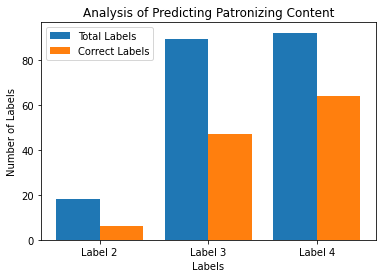

33.33% of patronizing content with label 2 are correctly predicted
52.81% of patronizing content with label 3 are correctly predicted
69.57% of patronizing content with label 4 are correctly predicted


In [ ]:
# Plot predictions for different levels of patronizing texts
model = torch.load("./model.pt")
preds, labels = test_model(model, tokenizer, BATCH_SIZE, MAX_LEN, dev_df, is_test=False)
correct_idx = get_correct_idx(preds, labels)
predict_patronize(model, dev_df, correct_idx)

In [ ]:
# How does the length of the input sequence impact the model performance?
# short: 0-50, medium: 50-100, long: 100+
import sys

def get_text_in_range(low, high, df):
    word_splits = df.text_preprocessed.str.split()
    drop_idx = []
    for idx, row in df.iterrows():
        word_count = len(word_splits[idx])
        if idx < len(df) and (word_count <= low or word_count > high):
            drop_idx.append(idx)
    df = df.drop(drop_idx)
    return df

df_dev_short = get_text_in_range(0, 50, dev_df)
df_dev_medium = get_text_in_range(50, 100, dev_df)
df_dev_long = get_text_in_range(100, sys.maxsize, dev_df)

def eval_performance(model, tokenizer, batch_size, tokenizer_max_len, test_df):
    test_dataset = DPMDataset(test_df)
    collate_fn = CollateSequence(tokenizer, tokenizer_max_len)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             collate_fn=collate_fn)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            input_ids, attn_mask, labels, keywords, countries = data
            input_ids = input_ids.to(device)
            attn_mask = attn_mask.to(device)
            labels = labels.to(device)
            cat_feats = torch.cat((keywords, countries), 1).to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attn_mask,
                            labels=labels,
                            cat_feats=cat_feats)
            
            predictions = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            all_preds.extend(predictions)

            labels = labels.detach().cpu().numpy()
            all_labels.extend(labels)
            
    acc = balanced_accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels,
                                                               all_preds,
                                                               average=None)

    return acc, precision, recall, f1


In [ ]:
acc_short, precision_short, recall_short, f1_short = eval_performance(model, tokenizer, BATCH_SIZE, MAX_LEN, df_dev_short)
acc_medium, precision_medium, recall_medium, f1_medium = eval_performance(model, tokenizer, BATCH_SIZE, MAX_LEN, df_dev_medium)
acc_long, precision_long, recall_long, f1_long = eval_performance(model, tokenizer, BATCH_SIZE, MAX_LEN, df_dev_long)

# Hyperparameter Tuning

In [ ]:
MODEL_NAME = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Learning Rate & Tokenizer Max Length

In [ ]:
def get_tokenized_lengths(df, tokenizer):
    all_lengths = []
    for text in df["text_preprocessed"]:
        tokens_dict = tokenizer(text, return_length=True)
        all_lengths.append(tokens_dict["length"])
    
    return all_lengths

def plot_tokenized_length_distribution(df, tokenizer, bins):
    tokenized_lengths = get_tokenized_lengths(train_df, tokenizer)
    lengths_df = pd.DataFrame(tokenized_lengths, columns=["length"])
    cuts = pd.cut(lengths_df.length, bins)
    lengths_df = lengths_df.groupby(cuts).size()

    fig, ax = plt.subplots(figsize=(8, 4), dpi=80)
    lengths_df.plot(kind="bar", ax=ax)
    plt.title("Tokenized Text Length Distribution")
    plt.show()

    count, _ = np.histogram(tokenized_lengths, bins)
    print(count)

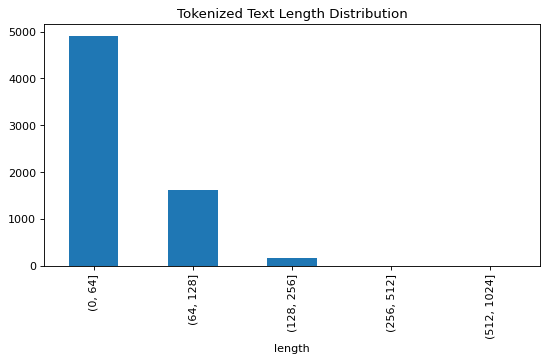

[4855 1657  183    3    2]


In [ ]:
plot_tokenized_length_distribution(train_df, tokenizer, bins=[0, 64, 128, 256, 512, 1024])

In [ ]:
BATCH_SIZE = 32 # fixed due to memory capacity
EPOCHS = 10
EPSILON = 1e-6  # same as HuggingFace default
tokenizer_max_lens = [64, 128]
lrs = [5e-6, 1e-5, 2e-5]

all_train_losses = []
all_dev_f1s = []

for max_len in tokenizer_max_lens:
    for lr in lrs:
        model = CustomBERT(MODEL_NAME).to(device)
        optimizer = AdamW(model.parameters(), lr=lr, eps=EPSILON)
        train_losses, dev_f1s = run_train(train_df,
                                          val_df,
                                          model,
                                          tokenizer,
                                          optimizer,
                                          BATCH_SIZE,
                                          max_len,
                                          epochs=EPOCHS)
        all_train_losses.append(train_losses)
        all_dev_f1s.append([dev[1] for dev in dev_f1s])

        print(f'=====lr = {lr}. len = {max_len}=====')
        print(train_losses)
        print(dev_f1s)

        with torch.no_grad():
            torch.cuda.empty_cache()

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Epoch: 1. Loss: 121.2419. Dev Acc: 0.8145. Dev Precision [0.99055713 0.24188312]. Dev Recall: [0.69195251 0.93710692]. Dev F1: [0.81475728 0.38451613].


Epoch 2: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.153]


Epoch: 2. Loss: 62.0827. Dev Acc: 0.8147. Dev Precision [0.97041847 0.4083045 ]. Dev Recall: [0.88720317 0.74213836]. Dev F1: [0.92694693 0.52678571].


Epoch 3: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.0392]


Epoch: 3. Loss: 46.7495. Dev Acc: 0.8081. Dev Precision [0.97100372 0.36363636]. Dev Recall: [0.86147757 0.75471698]. Dev F1: [0.91296749 0.49079755].


Epoch 4: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.021]


Epoch: 4. Loss: 34.5901. Dev Acc: 0.8095. Dev Precision [0.96861626 0.42124542]. Dev Recall: [0.89577836 0.72327044]. Dev F1: [0.9307745  0.53240741].


Epoch 5: 100%|██████████| 210/210 [01:09<00:00,  3.02batch/s, loss=0.11]


Epoch: 5. Loss: 23.8296. Dev Acc: 0.8025. Dev Precision [0.96537396 0.47186147]. Dev Recall: [0.91952507 0.68553459]. Dev F1: [0.94189189 0.55897436].


Epoch 6: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.00789]


Epoch: 6. Loss: 21.1956. Dev Acc: 0.8207. Dev Precision [0.97283407 0.38977636]. Dev Recall: [0.87401055 0.7672956 ]. Dev F1: [0.92077832 0.51694915].


Epoch 7: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.332]


Epoch: 7. Loss: 17.4460. Dev Acc: 0.7654. Dev Precision [0.956      0.53142857]. Dev Recall: [0.94591029 0.58490566]. Dev F1: [0.95092838 0.55688623].


Epoch 8: 100%|██████████| 210/210 [01:09<00:00,  3.02batch/s, loss=0.00974]


Epoch: 8. Loss: 17.0910. Dev Acc: 0.8049. Dev Precision [0.96643357 0.45306122]. Dev Recall: [0.9116095  0.69811321]. Dev F1: [0.93822132 0.54950495].


Epoch 9: 100%|██████████| 210/210 [01:09<00:00,  3.02batch/s, loss=0.0247]


Epoch: 9. Loss: 13.3224. Dev Acc: 0.7929. Dev Precision [0.96293754 0.48165138]. Dev Recall: [0.92546174 0.66037736]. Dev F1: [0.94382778 0.55702918].


Epoch 10: 100%|██████████| 210/210 [01:09<00:00,  3.02batch/s, loss=0.00963]


Epoch: 10. Loss: 11.7210. Dev Acc: 0.7954. Dev Precision [0.96354883 0.47963801]. Dev Recall: [0.92414248 0.66666667]. Dev F1: [0.94343434 0.55789474].
=====lr = 5e-06. len = 64=====
[121.24189420044422, 62.08265632018447, 46.74951322376728, 34.590082101523876, 23.829632338136435, 21.195571688003838, 17.44601278519258, 17.091046996880323, 13.322365320753306, 11.721027330495417]
[array([0.81475728, 0.38451613]), array([0.92694693, 0.52678571]), array([0.91296749, 0.49079755]), array([0.9307745 , 0.53240741]), array([0.94189189, 0.55897436]), array([0.92077832, 0.51694915]), array([0.95092838, 0.55688623]), array([0.93822132, 0.54950495]), array([0.94382778, 0.55702918]), array([0.94343434, 0.55789474])]


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Epoch: 1. Loss: 103.1004. Dev Acc: 0.8424. Dev Precision [0.97899475 0.38304094]. Dev Recall: [0.86081794 0.82389937]. Dev F1: [0.91611092 0.52295409].


Epoch 2: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.15]


Epoch: 2. Loss: 49.7251. Dev Acc: 0.7624. Dev Precision [0.95502646 0.55828221]. Dev Recall: [0.9525066  0.57232704]. Dev F1: [0.95376486 0.56521739].


Epoch 3: 100%|██████████| 210/210 [01:09<00:00,  3.02batch/s, loss=0.00551]


Epoch: 3. Loss: 32.5631. Dev Acc: 0.7928. Dev Precision [0.96421053 0.432     ]. Dev Recall: [0.90633245 0.67924528]. Dev F1: [0.93437606 0.52811736].


Epoch 4: 100%|██████████| 210/210 [01:09<00:00,  3.02batch/s, loss=0.0135]


Epoch: 4. Loss: 21.0085. Dev Acc: 0.7851. Dev Precision [0.9602961  0.52910053]. Dev Recall: [0.94129288 0.62893082]. Dev F1: [0.95069953 0.57471264].


Epoch 5: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.372]


Epoch: 5. Loss: 17.1435. Dev Acc: 0.7898. Dev Precision [0.96146045 0.52040816]. Dev Recall: [0.93799472 0.64150943]. Dev F1: [0.94958264 0.57464789].


Epoch 6: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.00828]


Epoch: 6. Loss: 12.4905. Dev Acc: 0.7889. Dev Precision [0.96099529 0.53723404]. Dev Recall: [0.94261214 0.63522013]. Dev F1: [0.95171495 0.58213256].


Epoch 7: 100%|██████████| 210/210 [01:09<00:00,  3.02batch/s, loss=0.00193]


Epoch: 7. Loss: 7.7198. Dev Acc: 0.7863. Dev Precision [0.96       0.56571429]. Dev Recall: [0.94986807 0.62264151]. Dev F1: [0.95490716 0.59281437].


Epoch 8: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.00159]


Epoch: 8. Loss: 6.0438. Dev Acc: 0.7644. Dev Precision [0.95520422 0.57961783]. Dev Recall: [0.95646438 0.57232704]. Dev F1: [0.95583388 0.57594937].


Epoch 9: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.00124]


Epoch: 9. Loss: 4.7252. Dev Acc: 0.7636. Dev Precision [0.95478375 0.60402685]. Dev Recall: [0.96108179 0.56603774]. Dev F1: [0.95792242 0.58441558].


Epoch 10: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.00114]


Epoch: 10. Loss: 6.4560. Dev Acc: 0.7573. Dev Precision [0.95353403 0.59863946]. Dev Recall: [0.96108179 0.55345912]. Dev F1: [0.95729304 0.5751634 ].
=====lr = 1e-05. len = 64=====
[103.100386030972, 49.72510198317468, 32.56312507065013, 21.008514070883393, 17.143533813767135, 12.490485318936408, 7.71980743505992, 6.043819535174407, 4.725153329083696, 6.4559818355483]
[array([0.91611092, 0.52295409]), array([0.95376486, 0.56521739]), array([0.93437606, 0.52811736]), array([0.95069953, 0.57471264]), array([0.94958264, 0.57464789]), array([0.95171495, 0.58213256]), array([0.95490716, 0.59281437]), array([0.95583388, 0.57594937]), array([0.95792242, 0.58441558]), array([0.95729304, 0.5751634 ])]


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Epoch: 1. Loss: 91.8927. Dev Acc: 0.7058. Dev Precision [0.94326241 0.57258065]. Dev Recall: [0.96503958 0.44654088]. Dev F1: [0.95402674 0.50176678].


Epoch 2: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.0103]


Epoch: 2. Loss: 36.1696. Dev Acc: 0.7561. Dev Precision [0.95376486 0.55279503]. Dev Recall: [0.9525066  0.55974843]. Dev F1: [0.95313531 0.55625   ].


Epoch 3: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.0862]


Epoch: 3. Loss: 21.3924. Dev Acc: 0.7593. Dev Precision [0.95439524 0.55555556]. Dev Recall: [0.9525066  0.56603774]. Dev F1: [0.95344998 0.56074766].


Epoch 4: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.0032]


Epoch: 4. Loss: 10.4613. Dev Acc: 0.7255. Dev Precision [0.94672657 0.64957265]. Dev Recall: [0.97295515 0.47798742]. Dev F1: [0.95966168 0.55072464].


Epoch 5: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.00129]


Epoch: 5. Loss: 7.3227. Dev Acc: 0.7238. Dev Precision [0.94655505 0.62295082]. Dev Recall: [0.96965699 0.47798742]. Dev F1: [0.95796676 0.54092527].


Epoch 6: 100%|██████████| 210/210 [01:09<00:00,  3.02batch/s, loss=0.000493]


Epoch: 6. Loss: 4.0110. Dev Acc: 0.7759. Dev Precision [0.95875592 0.5       ]. Dev Recall: [0.9353562 0.6163522]. Dev F1: [0.94691152 0.55211268].


Epoch 7: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.00044]


Epoch: 7. Loss: 2.3778. Dev Acc: 0.6874. Dev Precision [0.93899371 0.72941176]. Dev Recall: [0.9848285  0.38993711]. Dev F1: [0.9613651  0.50819672].


Epoch 8: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.000296]


Epoch: 8. Loss: 1.4395. Dev Acc: 0.7242. Dev Precision [0.94658945 0.62809917]. Dev Recall: [0.97031662 0.47798742]. Dev F1: [0.95830619 0.54285714].


Epoch 9: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.00652]


Epoch: 9. Loss: 1.4260. Dev Acc: 0.6945. Dev Precision [0.94050633 0.68421053]. Dev Recall: [0.98021108 0.40880503]. Dev F1: [0.95994832 0.51181102].


Epoch 10: 100%|██████████| 210/210 [01:09<00:00,  3.03batch/s, loss=0.000305]


Epoch: 10. Loss: 1.2488. Dev Acc: 0.6889. Dev Precision [0.93939394 0.69230769]. Dev Recall: [0.98153034 0.39622642]. Dev F1: [0.96  0.504].
=====lr = 2e-05. len = 64=====
[91.89265914261341, 36.16959291417152, 21.392370030283928, 10.461311155115254, 7.322658411168959, 4.011033280083211, 2.3778219460655237, 1.4395285752980271, 1.4260395916353446, 1.2488295767543605]
[array([0.95402674, 0.50176678]), array([0.95313531, 0.55625   ]), array([0.95344998, 0.56074766]), array([0.95966168, 0.55072464]), array([0.95796676, 0.54092527]), array([0.94691152, 0.55211268]), array([0.9613651 , 0.50819672]), array([0.95830619, 0.54285714]), array([0.95994832, 0.51181102]), array([0.96 , 0.504])]


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Epoch: 1. Loss: 118.7273. Dev Acc: 0.8258. Dev Precision [0.98543273 0.27952756]. Dev Recall: [0.7585752  0.89308176]. Dev F1: [0.85724935 0.42578711].


Epoch 2: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.0346]


Epoch: 2. Loss: 61.5491. Dev Acc: 0.8363. Dev Precision [0.97426733 0.44565217]. Dev Recall: [0.89907652 0.77358491]. Dev F1: [0.93516295 0.56551724].


Epoch 3: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.13]


Epoch: 3. Loss: 39.6954. Dev Acc: 0.8097. Dev Precision [0.96815287 0.4351145 ]. Dev Recall: [0.90237467 0.71698113]. Dev F1: [0.9341072 0.5415677].


Epoch 4: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.477]


Epoch: 4. Loss: 28.6793. Dev Acc: 0.8289. Dev Precision [0.97332372 0.42361111]. Dev Recall: [0.89050132 0.7672956 ]. Dev F1: [0.93007234 0.5458613 ].


Epoch 5: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.00863]


Epoch: 5. Loss: 21.2400. Dev Acc: 0.8098. Dev Precision [0.96678201 0.4826087 ]. Dev Recall: [0.92150396 0.69811321]. Dev F1: [0.94360014 0.57069409].


Epoch 6: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00619]


Epoch: 6. Loss: 17.2139. Dev Acc: 0.7995. Dev Precision [0.96428571 0.48858447]. Dev Recall: [0.92612137 0.67295597]. Dev F1: [0.9448183  0.56613757].


Epoch 7: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00432]


Epoch: 7. Loss: 12.2609. Dev Acc: 0.7972. Dev Precision [0.96326531 0.51219512]. Dev Recall: [0.93403694 0.66037736]. Dev F1: [0.94842599 0.57692308].


Epoch 8: 100%|██████████| 210/210 [01:55<00:00,  1.82batch/s, loss=0.403]


Epoch: 8. Loss: 9.3972. Dev Acc: 0.7926. Dev Precision [0.96208531 0.52020202]. Dev Recall: [0.93733509 0.64779874]. Dev F1: [0.94954895 0.57703081].


Epoch 9: 100%|██████████| 210/210 [01:55<00:00,  1.82batch/s, loss=0.00286]


Epoch: 9. Loss: 9.7261. Dev Acc: 0.7912. Dev Precision [0.96198235 0.50990099]. Dev Recall: [0.93469657 0.64779874]. Dev F1: [0.94814319 0.57063712].


Epoch 10: 100%|██████████| 210/210 [01:53<00:00,  1.84batch/s, loss=0.00338]


Epoch: 10. Loss: 10.0925. Dev Acc: 0.7945. Dev Precision [0.96223871 0.53645833]. Dev Recall: [0.94129288 0.64779874]. Dev F1: [0.95165055 0.58689459].
=====lr = 5e-06. len = 128=====
[118.72725862264633, 61.54908676818013, 39.695449098944664, 28.67934787273407, 21.239957408048213, 17.21394068840891, 12.260856427717954, 9.397201264742762, 9.726072393357754, 10.092548036482185]
[array([0.85724935, 0.42578711]), array([0.93516295, 0.56551724]), array([0.9341072, 0.5415677]), array([0.93007234, 0.5458613 ]), array([0.94360014, 0.57069409]), array([0.9448183 , 0.56613757]), array([0.94842599, 0.57692308]), array([0.94954895, 0.57703081]), array([0.94814319, 0.57063712]), array([0.95165055, 0.58689459])]


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Epoch: 1. Loss: 109.5174. Dev Acc: 0.8062. Dev Precision [0.9683908  0.40636042]. Dev Recall: [0.88918206 0.72327044]. Dev F1: [0.92709766 0.52036199].


Epoch 2: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.0113]


Epoch: 2. Loss: 47.9863. Dev Acc: 0.8214. Dev Precision [0.96940195 0.48523207]. Dev Recall: [0.91952507 0.72327044]. Dev F1: [0.94380501 0.58080808].


Epoch 3: 100%|██████████| 210/210 [01:53<00:00,  1.84batch/s, loss=0.395]


Epoch: 3. Loss: 26.3104. Dev Acc: 0.7796. Dev Precision [0.9586942  0.55747126]. Dev Recall: [0.94920844 0.61006289]. Dev F1: [0.95392774 0.58258258].


Epoch 4: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00482]


Epoch: 4. Loss: 17.6115. Dev Acc: 0.8041. Dev Precision [0.9637827  0.57065217]. Dev Recall: [0.94788918 0.66037736]. Dev F1: [0.95576987 0.6122449 ].


Epoch 5: 100%|██████████| 210/210 [01:53<00:00,  1.84batch/s, loss=0.00415]


Epoch: 5. Loss: 11.6488. Dev Acc: 0.7503. Dev Precision [0.95222513 0.58503401]. Dev Recall: [0.95976253 0.5408805 ]. Dev F1: [0.95597898 0.5620915 ].


Epoch 6: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.0013]


Epoch: 6. Loss: 6.9737. Dev Acc: 0.7624. Dev Precision [0.9543379  0.62676056]. Dev Recall: [0.96503958 0.55974843]. Dev F1: [0.9596589  0.59136213].


Epoch 7: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00147]


Epoch: 7. Loss: 6.7936. Dev Acc: 0.7346. Dev Precision [0.94851995 0.65289256]. Dev Recall: [0.97229551 0.49685535]. Dev F1: [0.96026059 0.56428571].


Epoch 8: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.000524]


Epoch: 8. Loss: 3.4845. Dev Acc: 0.7672. Dev Precision [0.95510735 0.65217391]. Dev Recall: [0.96833773 0.56603774]. Dev F1: [0.96167704 0.60606061].


Epoch 9: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.000587]


Epoch: 9. Loss: 2.2303. Dev Acc: 0.7753. Dev Precision [0.95686275 0.64137931]. Dev Recall: [0.96569921 0.58490566]. Dev F1: [0.96126067 0.61184211].


Epoch 10: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.000715]


Epoch: 10. Loss: 3.4923. Dev Acc: 0.7601. Dev Precision [0.95345831 0.6796875 ]. Dev Recall: [0.97295515 0.54716981]. Dev F1: [0.96310806 0.60627178].
=====lr = 1e-05. len = 128=====
[109.51741995662451, 47.98634082451463, 26.310420220717788, 17.61151347728446, 11.64875642163679, 6.973716214997694, 6.793632844346575, 3.4844888722873293, 2.230335520755034, 3.4922995018132497]
[array([0.92709766, 0.52036199]), array([0.94380501, 0.58080808]), array([0.95392774, 0.58258258]), array([0.95576987, 0.6122449 ]), array([0.95597898, 0.5620915 ]), array([0.9596589 , 0.59136213]), array([0.96026059, 0.56428571]), array([0.96167704, 0.60606061]), array([0.96126067, 0.61184211]), array([0.96310806, 0.60627178])]


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Epoch: 1. Loss: 88.2973. Dev Acc: 0.8466. Dev Precision [0.97805413 0.41883117]. Dev Recall: [0.88192612 0.81132075]. Dev F1: [0.92750607 0.55246253].


Epoch 2: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.0147]


Epoch: 2. Loss: 35.8426. Dev Acc: 0.8475. Dev Precision [0.97866078 0.41139241]. Dev Recall: [0.87730871 0.81761006]. Dev F1: [0.92521739 0.54736842].


Epoch 3: 100%|██████████| 210/210 [01:55<00:00,  1.82batch/s, loss=0.387]


Epoch: 3. Loss: 21.4273. Dev Acc: 0.7924. Dev Precision [0.96166779 0.54255319]. Dev Recall: [0.94327177 0.64150943]. Dev F1: [0.95238095 0.58789625].


Epoch 4: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.00206]


Epoch: 4. Loss: 13.8625. Dev Acc: 0.8411. Dev Precision [0.97401685 0.48605578]. Dev Recall: [0.91490765 0.7672956 ]. Dev F1: [0.94353741 0.59512195].


Epoch 5: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.00213]


Epoch: 5. Loss: 11.0467. Dev Acc: 0.7122. Dev Precision [0.94370651 0.74468085]. Dev Recall: [0.98416887 0.44025157]. Dev F1: [0.96351308 0.55335968].


Epoch 6: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.472]


Epoch: 6. Loss: 7.1324. Dev Acc: 0.7697. Dev Precision [0.95567145 0.64539007]. Dev Recall: [0.96701847 0.57232704]. Dev F1: [0.96131148 0.60666667].


Epoch 7: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.000501]


Epoch: 7. Loss: 3.2468. Dev Acc: 0.7352. Dev Precision [0.94858612 0.66386555]. Dev Recall: [0.97361478 0.49685535]. Dev F1: [0.9609375  0.56834532].


Epoch 8: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.000387]


Epoch: 8. Loss: 2.7236. Dev Acc: 0.7352. Dev Precision [0.94858612 0.66386555]. Dev Recall: [0.97361478 0.49685535]. Dev F1: [0.9609375  0.56834532].


Epoch 9: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.000201]


Epoch: 9. Loss: 1.6909. Dev Acc: 0.7222. Dev Precision [0.94582537 0.69811321]. Dev Recall: [0.97889182 0.46540881]. Dev F1: [0.96207455 0.55849057].


Epoch 10: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.000393]


Epoch: 10. Loss: 0.5327. Dev Acc: 0.7356. Dev Precision [0.94861914 0.66949153]. Dev Recall: [0.97427441 0.49685535]. Dev F1: [0.96127563 0.57039711].
=====lr = 2e-05. len = 128=====
[88.29729498177767, 35.84255663584918, 21.427270451094955, 13.862536373198964, 11.046712195733562, 7.132410555961542, 3.2467917783069424, 2.7235541605041362, 1.6909095276350854, 0.5327352400927339]
[array([0.92750607, 0.55246253]), array([0.92521739, 0.54736842]), array([0.95238095, 0.58789625]), array([0.94353741, 0.59512195]), array([0.96351308, 0.55335968]), array([0.96131148, 0.60666667]), array([0.9609375 , 0.56834532]), array([0.9609375 , 0.56834532]), array([0.96207455, 0.55849057]), array([0.96127563, 0.57039711])]


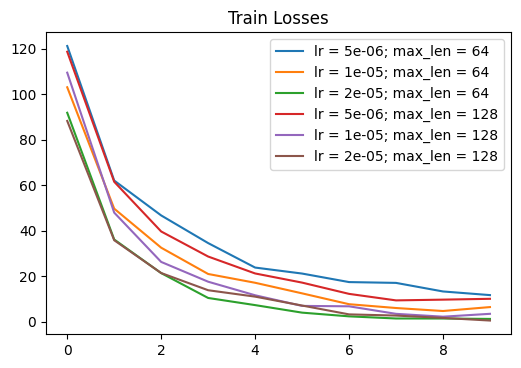

In [ ]:
plt.figure(dpi=100)
for i, dev_f1s in enumerate(all_train_losses):
    a, b = divmod(i, len(lrs))
    plt.plot(dev_f1s, label=f"lr = {lrs[b]}; max_len = {tokenizer_max_lens[a]}")
plt.legend()
plt.title("Train Losses")
plt.show()

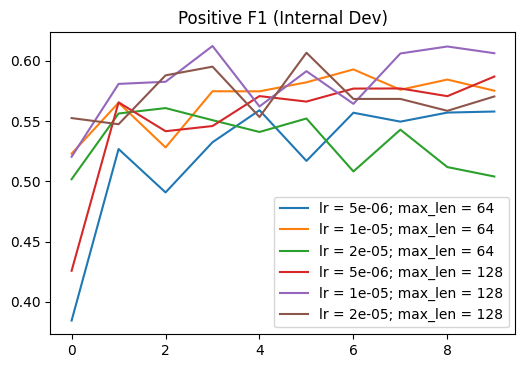

In [ ]:
plt.figure(dpi=100)
for i, dev_f1s in enumerate(all_dev_f1s):
    a, b = divmod(i, len(lrs))
    plt.plot(dev_f1s, label=f"lr = {lrs[b]}; max_len = {tokenizer_max_lens[a]}")
plt.legend()
plt.title("Positive F1 (Internal Dev)")
plt.show()

In [ ]:
for i, dev_f1s in enumerate(all_dev_f1s):
    a, b = divmod(i, len(lrs))
    print(f"lr = {lrs[b]}; max_len = {tokenizer_max_lens[a]}. Final Pos F1 (Internal Dev): {dev_f1s[-1]}")

lr = 5e-06; max_len = 64. Final Pos F1 (Internal Dev): 0.5578947368421052
lr = 1e-05; max_len = 64. Final Pos F1 (Internal Dev): 0.5751633986928104
lr = 2e-05; max_len = 64. Final Pos F1 (Internal Dev): 0.5040000000000001
lr = 5e-06; max_len = 128. Final Pos F1 (Internal Dev): 0.586894586894587
lr = 1e-05; max_len = 128. Final Pos F1 (Internal Dev): 0.6062717770034842
lr = 2e-05; max_len = 128. Final Pos F1 (Internal Dev): 0.5703971119133574


## Weight Decay & Dropout Probability

In [ ]:
BATCH_SIZE = 32 # fixed due to memory capacity
EPOCHS = 10
EPSILON = 1e-6  # same as HuggingFace default
LEARNING_RATE = 1e-5
MAX_LEN = 128
weight_decays = [0.005, 0.01, 0.02]
dropout_probs = [0.1, 0.2, 0.3]

all_train_losses = []
all_dev_f1s = []

for w_decay in weight_decays:
    for dropout_prob in dropout_probs:
        model = CustomBERT(MODEL_NAME, dropout_prob=dropout_prob).to(device)
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON,
                          weight_decay=w_decay)
        train_losses, dev_f1s = run_train(train_df,
                                          val_df,
                                          model,
                                          tokenizer,
                                          optimizer,
                                          BATCH_SIZE,
                                          MAX_LEN,
                                          epochs=EPOCHS)
        all_train_losses.append(train_losses)
        all_dev_f1s.append([dev[1] for dev in dev_f1s])

        print(f'=====w_decay = {w_decay}. dropout_prob = {dropout_prob}=====')
        print(train_losses)
        print([dev[1] for dev in dev_f1s])
        print('\n')

        with torch.no_grad():
            torch.cuda.empty_cache()

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Epoch: 1. Loss: 99.1344. Dev Acc: 0.8304. Dev Precision [0.97289586 0.44322344]. Dev Recall: [0.89973615 0.76100629]. Dev F1: [0.93488691 0.56018519].


Epoch 2: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.226]


Epoch: 2. Loss: 43.3658. Dev Acc: 0.7974. Dev Precision [0.96369863 0.49302326]. Dev Recall: [0.92810026 0.66666667]. Dev F1: [0.94556452 0.56684492].


Epoch 3: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.0191]


Epoch: 3. Loss: 23.9175. Dev Acc: 0.7907. Dev Precision [0.96074518 0.58139535]. Dev Recall: [0.9525066  0.62893082]. Dev F1: [0.95660815 0.60422961].


Epoch 4: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00484]


Epoch: 4. Loss: 17.8557. Dev Acc: 0.7856. Dev Precision [0.9599466  0.55932203]. Dev Recall: [0.94854881 0.62264151]. Dev F1: [0.95421367 0.58928571].


Epoch 5: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00386]


Epoch: 5. Loss: 11.8623. Dev Acc: 0.8022. Dev Precision [0.96363636 0.55263158]. Dev Recall: [0.9439314  0.66037736]. Dev F1: [0.95368211 0.6017192 ].


Epoch 6: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.00265]


Epoch: 6. Loss: 7.1010. Dev Acc: 0.7846. Dev Precision [0.95986622 0.55      ]. Dev Recall: [0.94656992 0.62264151]. Dev F1: [0.9531717 0.5840708].


Epoch 7: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00281]


Epoch: 7. Loss: 7.1619. Dev Acc: 0.7904. Dev Precision [0.96151249 0.5257732 ]. Dev Recall: [0.93931398 0.64150943]. Dev F1: [0.95028362 0.57790368].


Epoch 8: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00343]


Epoch: 8. Loss: 6.4343. Dev Acc: 0.7755. Dev Precision [0.95797198 0.54545455]. Dev Recall: [0.94722955 0.60377358]. Dev F1: [0.95257048 0.57313433].


Epoch 9: 100%|██████████| 210/210 [01:53<00:00,  1.84batch/s, loss=0.00145]


Epoch: 9. Loss: 4.8365. Dev Acc: 0.7647. Dev Precision [0.95523371 0.58333333]. Dev Recall: [0.95712401 0.57232704]. Dev F1: [0.95617792 0.57777778].


Epoch 10: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00117]


Epoch: 10. Loss: 3.4268. Dev Acc: 0.7613. Dev Precision [0.95457538 0.57692308]. Dev Recall: [0.95646438 0.56603774]. Dev F1: [0.95551895 0.57142857].
=====w_decay = 0.005. dropout_prob = 0.1=====
[99.13437408953905, 43.365826888009906, 23.917489276267588, 17.855662253918126, 11.862261099275202, 7.100984524586238, 7.161925256601535, 6.434278255212121, 4.83647039567586, 3.426764585718047]
[0.5601851851851852, 0.5668449197860963, 0.6042296072507554, 0.5892857142857142, 0.6017191977077364, 0.5840707964601771, 0.5779036827195467, 0.573134328358209, 0.5777777777777778, 0.5714285714285713]




Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Epoch: 1. Loss: 97.8879. Dev Acc: 0.7891. Dev Precision [0.96140826 0.51515152]. Dev Recall: [0.93667546 0.64150943]. Dev F1: [0.94888072 0.57142857].


Epoch 2: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.098]


Epoch: 2. Loss: 46.8919. Dev Acc: 0.8040. Dev Precision [0.9659249  0.46413502]. Dev Recall: [0.91622691 0.6918239 ]. Dev F1: [0.94041977 0.55555556].


Epoch 3: 100%|██████████| 210/210 [01:53<00:00,  1.86batch/s, loss=0.0147]


Epoch: 3. Loss: 27.4513. Dev Acc: 0.7732. Dev Precision [0.957039   0.58024691]. Dev Recall: [0.95514512 0.59119497]. Dev F1: [0.95609112 0.58566978].


Epoch 4: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.05]


Epoch: 4. Loss: 17.7222. Dev Acc: 0.8264. Dev Precision [0.97067039 0.48148148]. Dev Recall: [0.91688654 0.73584906]. Dev F1: [0.94301221 0.58208955].


Epoch 5: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.0133]


Epoch: 5. Loss: 11.0611. Dev Acc: 0.7591. Dev Precision [0.95403808 0.58552632]. Dev Recall: [0.95844327 0.55974843]. Dev F1: [0.9562356  0.57234727].


Epoch 6: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.00171]


Epoch: 6. Loss: 7.2417. Dev Acc: 0.7414. Dev Precision [0.95009721 0.62121212]. Dev Recall: [0.96701847 0.51572327]. Dev F1: [0.95848316 0.56357388].


Epoch 7: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.0011]


Epoch: 7. Loss: 6.6181. Dev Acc: 0.6952. Dev Precision [0.94058154 0.69892473]. Dev Recall: [0.98153034 0.40880503]. Dev F1: [0.96061975 0.51587302].


Epoch 8: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.0014]


Epoch: 8. Loss: 4.3766. Dev Acc: 0.7472. Dev Precision [0.95096774 0.664     ]. Dev Recall: [0.97229551 0.52201258]. Dev F1: [0.96151337 0.58450704].


Epoch 9: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.000879]


Epoch: 9. Loss: 3.2133. Dev Acc: 0.7380. Dev Precision [0.94916345 0.66115702]. Dev Recall: [0.97295515 0.50314465]. Dev F1: [0.96091205 0.57142857].


Epoch 10: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.00101]


Epoch: 10. Loss: 3.6581. Dev Acc: 0.7380. Dev Precision [0.94916345 0.66115702]. Dev Recall: [0.97295515 0.50314465]. Dev F1: [0.96091205 0.57142857].
=====w_decay = 0.005. dropout_prob = 0.2=====
[97.887869104743, 46.891862192191184, 27.451280186884105, 17.722156720934436, 11.061131787486374, 7.241659439867362, 6.6180535345338285, 4.376570305088535, 3.2132695667096414, 3.658107593189925]
[0.5714285714285715, 0.5555555555555556, 0.5856697819314642, 0.5820895522388059, 0.572347266881029, 0.563573883161512, 0.5158730158730159, 0.5845070422535211, 0.5714285714285715, 0.5714285714285715]




Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Epoch: 1. Loss: 108.1114. Dev Acc: 0.8375. Dev Precision [0.97703704 0.39384615]. Dev Recall: [0.87005277 0.80503145]. Dev F1: [0.92044662 0.52892562].


Epoch 2: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.745]


Epoch: 2. Loss: 52.8080. Dev Acc: 0.8364. Dev Precision [0.97532656 0.42087542]. Dev Recall: [0.88654354 0.78616352]. Dev F1: [0.92881824 0.54824561].


Epoch 3: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.0252]


Epoch: 3. Loss: 29.5272. Dev Acc: 0.8289. Dev Precision [0.97130861 0.4796748 ]. Dev Recall: [0.91556728 0.74213836]. Dev F1: [0.9426146  0.58271605].


Epoch 4: 100%|██████████| 210/210 [01:53<00:00,  1.84batch/s, loss=0.00569]


Epoch: 4. Loss: 18.8312. Dev Acc: 0.8136. Dev Precision [0.9665985  0.52884615]. Dev Recall: [0.9353562 0.6918239]. Dev F1: [0.95072075 0.59945504].


Epoch 5: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.0111]


Epoch: 5. Loss: 19.0064. Dev Acc: 0.8340. Dev Precision [0.97310686 0.46183206]. Dev Recall: [0.90699208 0.76100629]. Dev F1: [0.93888699 0.57482185].


Epoch 6: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00504]


Epoch: 6. Loss: 11.4909. Dev Acc: 0.7722. Dev Precision [0.95695364 0.56969697]. Dev Recall: [0.95316623 0.59119497]. Dev F1: [0.95505618 0.58024691].


Epoch 7: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.00498]


Epoch: 7. Loss: 9.0309. Dev Acc: 0.7623. Dev Precision [0.95536309 0.52873563]. Dev Recall: [0.94591029 0.57861635]. Dev F1: [0.95061319 0.55255255].


Epoch 8: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.00197]


Epoch: 8. Loss: 6.0230. Dev Acc: 0.7801. Dev Precision [0.95911528 0.53551913]. Dev Recall: [0.9439314 0.6163522]. Dev F1: [0.95146277 0.57309942].


Epoch 9: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.00211]


Epoch: 9. Loss: 5.6739. Dev Acc: 0.7714. Dev Precision [0.95724783 0.53370787]. Dev Recall: [0.94525066 0.59748428]. Dev F1: [0.95121142 0.56379822].


Epoch 10: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00121]


Epoch: 10. Loss: 5.4885. Dev Acc: 0.7642. Dev Precision [0.95554081 0.54761905]. Dev Recall: [0.94986807 0.57861635]. Dev F1: [0.952696   0.56269113].
=====w_decay = 0.005. dropout_prob = 0.3=====
[108.1113687902689, 52.80796259641647, 29.527194103226066, 18.83124866290018, 19.00640914682299, 11.49093570257537, 9.030897331889719, 6.022961234557442, 5.673866862663999, 5.488504819106311]
[0.5289256198347109, 0.5482456140350878, 0.582716049382716, 0.5994550408719346, 0.5748218527315914, 0.5802469135802469, 0.5525525525525525, 0.5730994152046783, 0.5637982195845698, 0.5626911314984709]




Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Epoch: 1. Loss: 95.9842. Dev Acc: 0.8273. Dev Precision [0.97649735 0.35955056]. Dev Recall: [0.84960422 0.80503145]. Dev F1: [0.90864198 0.49708738].


Epoch 2: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.138]


Epoch: 2. Loss: 46.1827. Dev Acc: 0.7399. Dev Precision [0.95026178 0.56462585]. Dev Recall: [0.95778364 0.52201258]. Dev F1: [0.95400788 0.54248366].


Epoch 3: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.0318]


Epoch: 3. Loss: 28.9003. Dev Acc: 0.7843. Dev Precision [0.96062458 0.5       ]. Dev Recall: [0.93337731 0.63522013]. Dev F1: [0.94680495 0.55955679].


Epoch 4: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00435]


Epoch: 4. Loss: 16.9811. Dev Acc: 0.7483. Dev Precision [0.95203679 0.5620915 ]. Dev Recall: [0.95580475 0.5408805 ]. Dev F1: [0.95391705 0.55128205].


Epoch 5: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.0047]


Epoch: 5. Loss: 12.0642. Dev Acc: 0.7429. Dev Precision [0.95055303 0.60144928]. Dev Recall: [0.96372032 0.52201258]. Dev F1: [0.95709139 0.55892256].


Epoch 6: 100%|██████████| 210/210 [01:53<00:00,  1.84batch/s, loss=0.00154]


Epoch: 6. Loss: 7.6485. Dev Acc: 0.7515. Dev Precision [0.95266272 0.56493506]. Dev Recall: [0.95580475 0.54716981]. Dev F1: [0.95423115 0.55591054].


Epoch 7: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.000862]


Epoch: 7. Loss: 7.7662. Dev Acc: 0.7116. Dev Precision [0.94415918 0.61538462]. Dev Recall: [0.97031662 0.45283019]. Dev F1: [0.95705921 0.52173913].


Epoch 8: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.000657]


Epoch: 8. Loss: 4.8800. Dev Acc: 0.7101. Dev Precision [0.94373402 0.63963964]. Dev Recall: [0.97361478 0.44654088]. Dev F1: [0.95844156 0.52592593].


Epoch 9: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.000855]


Epoch: 9. Loss: 4.9111. Dev Acc: 0.7357. Dev Precision [0.94893342 0.625     ]. Dev Recall: [0.96833773 0.50314465]. Dev F1: [0.95853738 0.55749129].


Epoch 10: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.000646]


Epoch: 10. Loss: 3.9654. Dev Acc: 0.7301. Dev Precision [0.94777563 0.62903226]. Dev Recall: [0.96965699 0.49056604]. Dev F1: [0.95859146 0.55123675].
=====w_decay = 0.01. dropout_prob = 0.1=====
[95.98418904840946, 46.182727973908186, 28.900269117206335, 16.981123972451314, 12.06424357520882, 7.648531175684184, 7.7661754811997525, 4.880009048676584, 4.911069875583053, 3.965405942988582]
[0.4970873786407767, 0.5424836601307189, 0.5595567867036011, 0.5512820512820513, 0.5589225589225588, 0.5559105431309904, 0.5217391304347827, 0.5259259259259259, 0.5574912891986064, 0.5512367491166077]




Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Epoch: 1. Loss: 99.0330. Dev Acc: 0.8235. Dev Precision [0.97572079 0.3557423 ]. Dev Recall: [0.84828496 0.79874214]. Dev F1: [0.90755116 0.49224806].


Epoch 2: 100%|██████████| 210/210 [01:53<00:00,  1.84batch/s, loss=0.0438]


Epoch: 2. Loss: 45.8763. Dev Acc: 0.8343. Dev Precision [0.97312588 0.46360153]. Dev Recall: [0.90765172 0.76100629]. Dev F1: [0.93924915 0.57619048].


Epoch 3: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.0272]


Epoch: 3. Loss: 28.2747. Dev Acc: 0.7912. Dev Precision [0.96198235 0.50990099]. Dev Recall: [0.93469657 0.64779874]. Dev F1: [0.94814319 0.57063712].


Epoch 4: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.0061]


Epoch: 4. Loss: 19.6156. Dev Acc: 0.8111. Dev Precision [0.96687371 0.49115044]. Dev Recall: [0.92414248 0.69811321]. Dev F1: [0.9450253  0.57662338].


Epoch 5: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.00549]


Epoch: 5. Loss: 12.5734. Dev Acc: 0.7869. Dev Precision [0.96005326 0.57225434]. Dev Recall: [0.95118734 0.62264151]. Dev F1: [0.95559973 0.59638554].


Epoch 6: 100%|██████████| 210/210 [01:52<00:00,  1.86batch/s, loss=0.00177]


Epoch: 6. Loss: 10.8990. Dev Acc: 0.7662. Dev Precision [0.95571712 0.56790123]. Dev Recall: [0.95382586 0.57861635]. Dev F1: [0.95477055 0.57320872].


Epoch 7: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.00174]


Epoch: 7. Loss: 7.6422. Dev Acc: 0.7454. Dev Precision [0.95110821 0.59574468]. Dev Recall: [0.96240106 0.52830189]. Dev F1: [0.95672131 0.56      ].


Epoch 8: 100%|██████████| 210/210 [01:53<00:00,  1.84batch/s, loss=0.00139]


Epoch: 8. Loss: 5.7623. Dev Acc: 0.7975. Dev Precision [0.96329028 0.51470588]. Dev Recall: [0.93469657 0.66037736]. Dev F1: [0.94877804 0.5785124 ].


Epoch 9: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.00124]


Epoch: 9. Loss: 4.6080. Dev Acc: 0.7621. Dev Precision [0.95499669 0.55487805]. Dev Recall: [0.95184697 0.57232704]. Dev F1: [0.95341923 0.56346749].


Epoch 10: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00102]


Epoch: 10. Loss: 2.6987. Dev Acc: 0.7589. Dev Precision [0.95436508 0.55214724]. Dev Recall: [0.95184697 0.56603774]. Dev F1: [0.95310436 0.55900621].
=====w_decay = 0.01. dropout_prob = 0.2=====
[99.03304738551378, 45.87630481272936, 28.274697160813957, 19.61561863962561, 12.57341922284104, 10.89898186083883, 7.642206314718351, 5.762297565932386, 4.608010628959164, 2.6987244293559343]
[0.4922480620155039, 0.5761904761904764, 0.5706371191135734, 0.5766233766233766, 0.5963855421686747, 0.573208722741433, 0.56, 0.5785123966942147, 0.563467492260062, 0.5590062111801242]




Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Epoch: 1. Loss: 107.3275. Dev Acc: 0.8014. Dev Precision [0.96664301 0.42105263]. Dev Recall: [0.89841689 0.70440252]. Dev F1: [0.93128205 0.52705882].


Epoch 2: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.357]


Epoch: 2. Loss: 53.8758. Dev Acc: 0.7868. Dev Precision [0.96042924 0.54347826]. Dev Recall: [0.94459103 0.62893082]. Dev F1: [0.9524443  0.58309038].


Epoch 3: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.439]


Epoch: 3. Loss: 34.7257. Dev Acc: 0.7863. Dev Precision [0.96078431 0.51530612]. Dev Recall: [0.93733509 0.63522013]. Dev F1: [0.94891486 0.56901408].


Epoch 4: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.00395]


Epoch: 4. Loss: 19.0143. Dev Acc: 0.7861. Dev Precision [0.96037609 0.53763441]. Dev Recall: [0.94327177 0.62893082]. Dev F1: [0.95174709 0.57971014].


Epoch 5: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.00288]


Epoch: 5. Loss: 13.4988. Dev Acc: 0.7932. Dev Precision [0.96213658 0.5255102 ]. Dev Recall: [0.93865435 0.64779874]. Dev F1: [0.95025042 0.58028169].


Epoch 6: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00167]


Epoch: 6. Loss: 7.9612. Dev Acc: 0.7715. Dev Precision [0.95689655 0.56287425]. Dev Recall: [0.95184697 0.59119497]. Dev F1: [0.95436508 0.57668712].


Epoch 7: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.0013]


Epoch: 7. Loss: 6.9292. Dev Acc: 0.7339. Dev Precision [0.94845361 0.64227642]. Dev Recall: [0.97097625 0.49685535]. Dev F1: [0.95958279 0.56028369].


Epoch 8: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.0038]


Epoch: 8. Loss: 5.3455. Dev Acc: 0.7177. Dev Precision [0.94508301 0.66972477]. Dev Recall: [0.9762533 0.4591195]. Dev F1: [0.96041531 0.54477612].


Epoch 9: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00112]


Epoch: 9. Loss: 4.1743. Dev Acc: 0.7561. Dev Precision [0.95309446 0.62142857]. Dev Recall: [0.96503958 0.54716981]. Dev F1: [0.95902983 0.5819398 ].


Epoch 10: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.000995]


Epoch: 10. Loss: 2.5008. Dev Acc: 0.7405. Dev Precision [0.94970986 0.65322581]. Dev Recall: [0.97163588 0.50943396]. Dev F1: [0.96054777 0.57243816].
=====w_decay = 0.01. dropout_prob = 0.3=====
[107.3274996727705, 53.875848699361086, 34.725713218562305, 19.014341599307954, 13.498788557946682, 7.961237159674056, 6.929159788182005, 5.345495724235661, 4.174317970057018, 2.500800794339739]
[0.5270588235294118, 0.5830903790087463, 0.5690140845070423, 0.5797101449275363, 0.580281690140845, 0.5766871165644172, 0.5602836879432626, 0.5447761194029851, 0.5819397993311036, 0.5724381625441697]




Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Epoch: 1. Loss: 97.5287. Dev Acc: 0.8115. Dev Precision [0.98879552 0.24337748]. Dev Recall: [0.69854881 0.9245283 ]. Dev F1: [0.81870893 0.3853211 ].


Epoch 2: 100%|██████████| 210/210 [01:53<00:00,  1.84batch/s, loss=0.0307]


Epoch: 2. Loss: 46.5984. Dev Acc: 0.8035. Dev Precision [0.96457766 0.51690821]. Dev Recall: [0.93403694 0.67295597]. Dev F1: [0.94906166 0.58469945].


Epoch 3: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.448]


Epoch: 3. Loss: 29.9395. Dev Acc: 0.8221. Dev Precision [0.97040169 0.45703125]. Dev Recall: [0.90831135 0.73584906]. Dev F1: [0.93833049 0.56385542].


Epoch 4: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00777]


Epoch: 4. Loss: 17.1975. Dev Acc: 0.8075. Dev Precision [0.96572995 0.50462963]. Dev Recall: [0.92941953 0.68553459]. Dev F1: [0.94722689 0.58133333].


Epoch 5: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.00583]


Epoch: 5. Loss: 14.3150. Dev Acc: 0.8010. Dev Precision [0.96397009 0.51960784]. Dev Recall: [0.9353562  0.66666667]. Dev F1: [0.94944761 0.58402204].


Epoch 6: 100%|██████████| 210/210 [01:55<00:00,  1.83batch/s, loss=0.397]


Epoch: 6. Loss: 12.2637. Dev Acc: 0.8171. Dev Precision [0.96818811 0.49344978]. Dev Recall: [0.92348285 0.71069182]. Dev F1: [0.94530722 0.58247423].


Epoch 7: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00235]


Epoch: 7. Loss: 6.9861. Dev Acc: 0.7717. Dev Precision [0.95727637 0.53672316]. Dev Recall: [0.94591029 0.59748428]. Dev F1: [0.95155939 0.56547619].


Epoch 8: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00243]


Epoch: 8. Loss: 5.1217. Dev Acc: 0.7578. Dev Precision [0.95391705 0.57051282]. Dev Recall: [0.95580475 0.55974843]. Dev F1: [0.95485997 0.56507937].


Epoch 9: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00137]


Epoch: 9. Loss: 4.3886. Dev Acc: 0.7792. Dev Precision [0.95903291 0.52688172]. Dev Recall: [0.94195251 0.6163522 ]. Dev F1: [0.95041597 0.56811594].


Epoch 10: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.241]


Epoch: 10. Loss: 3.5479. Dev Acc: 0.7679. Dev Precision [0.95586298 0.58598726]. Dev Recall: [0.95712401 0.57861635]. Dev F1: [0.95649308 0.58227848].
=====w_decay = 0.02. dropout_prob = 0.1=====
[97.52867184579372, 46.598417380824685, 29.93954831548035, 17.197515297681093, 14.31504341843538, 12.263656822731718, 6.98611302417703, 5.121706383943092, 4.38860240962822, 3.547859429207165]
[0.3853211009174312, 0.5846994535519124, 0.5638554216867468, 0.5813333333333333, 0.5840220385674931, 0.5824742268041236, 0.5654761904761904, 0.5650793650793651, 0.5681159420289855, 0.5822784810126582]




Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Epoch: 1. Loss: 101.6622. Dev Acc: 0.8241. Dev Precision [0.9725235  0.41438356]. Dev Recall: [0.88720317 0.76100629]. Dev F1: [0.92790617 0.53658537].


Epoch 2: 100%|██████████| 210/210 [01:53<00:00,  1.84batch/s, loss=0.158]


Epoch: 2. Loss: 43.0845. Dev Acc: 0.8365. Dev Precision [0.97480202 0.43356643]. Dev Recall: [0.89313984 0.77987421]. Dev F1: [0.93218589 0.55730337].


Epoch 3: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.0152]


Epoch: 3. Loss: 23.8587. Dev Acc: 0.8212. Dev Precision [0.96892265 0.50220264]. Dev Recall: [0.92546174 0.71698113]. Dev F1: [0.94669366 0.59067358].


Epoch 4: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00391]


Epoch: 4. Loss: 18.2647. Dev Acc: 0.8224. Dev Precision [0.96853625 0.53051643]. Dev Recall: [0.93403694 0.71069182]. Dev F1: [0.95097381 0.60752688].


Epoch 5: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.00382]


Epoch: 5. Loss: 12.8398. Dev Acc: 0.8002. Dev Precision [0.96266667 0.58857143]. Dev Recall: [0.9525066  0.64779874]. Dev F1: [0.95755968 0.61676647].


Epoch 6: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00299]


Epoch: 6. Loss: 7.6260. Dev Acc: 0.8045. Dev Precision [0.9646499 0.5245098]. Dev Recall: [0.93601583 0.67295597]. Dev F1: [0.95011717 0.58953168].


Epoch 7: 100%|██████████| 210/210 [01:53<00:00,  1.84batch/s, loss=0.00177]


Epoch: 7. Loss: 6.8559. Dev Acc: 0.8045. Dev Precision [0.96380697 0.57377049]. Dev Recall: [0.94854881 0.66037736]. Dev F1: [0.95611702 0.61403509].


Epoch 8: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.00116]


Epoch: 8. Loss: 6.2615. Dev Acc: 0.7924. Dev Precision [0.96166779 0.54255319]. Dev Recall: [0.94327177 0.64150943]. Dev F1: [0.95238095 0.58789625].


Epoch 9: 100%|██████████| 210/210 [01:55<00:00,  1.83batch/s, loss=0.000922]


Epoch: 9. Loss: 4.5474. Dev Acc: 0.7790. Dev Precision [0.95789474 0.61290323]. Dev Recall: [0.96042216 0.59748428]. Dev F1: [0.95915679 0.60509554].


Epoch 10: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.000753]


Epoch: 10. Loss: 2.4213. Dev Acc: 0.7748. Dev Precision [0.9571805  0.59872611]. Dev Recall: [0.95844327 0.59119497]. Dev F1: [0.95781147 0.59493671].
=====w_decay = 0.02. dropout_prob = 0.2=====
[101.66216714680195, 43.084517342969775, 23.858732115477324, 18.26466310536489, 12.839783167466521, 7.625960071687587, 6.855890835751779, 6.261478052765597, 4.5474228439852595, 2.4212564491317607]
[0.5365853658536585, 0.5573033707865169, 0.5906735751295337, 0.6075268817204301, 0.6167664670658681, 0.5895316804407713, 0.6140350877192982, 0.5878962536023054, 0.6050955414012739, 0.5949367088607594]




Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Epoch: 1. Loss: 102.2035. Dev Acc: 0.8229. Dev Precision [0.98680739 0.26765799]. Dev Recall: [0.74010554 0.90566038]. Dev F1: [0.8458349  0.41319943].


Epoch 2: 100%|██████████| 210/210 [01:53<00:00,  1.84batch/s, loss=0.144]


Epoch: 2. Loss: 49.2417. Dev Acc: 0.8322. Dev Precision [0.97351467 0.43884892]. Dev Recall: [0.89709763 0.7672956 ]. Dev F1: [0.93374528 0.5583524 ].


Epoch 3: 100%|██████████| 210/210 [01:53<00:00,  1.85batch/s, loss=0.218]


Epoch: 3. Loss: 22.6729. Dev Acc: 0.7965. Dev Precision [0.96239087 0.55376344]. Dev Recall: [0.94525066 0.64779874]. Dev F1: [0.95374376 0.59710145].


Epoch 4: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.00364]


Epoch: 4. Loss: 16.3461. Dev Acc: 0.8168. Dev Precision [0.97006415 0.43014706]. Dev Recall: [0.89775726 0.73584906]. Dev F1: [0.93251113 0.54292343].


Epoch 5: 100%|██████████| 210/210 [01:52<00:00,  1.86batch/s, loss=0.00125]


Epoch: 5. Loss: 11.3943. Dev Acc: 0.8088. Dev Precision [0.96495957 0.56020942]. Dev Recall: [0.94459103 0.67295597]. Dev F1: [0.95466667 0.61142857].


Epoch 6: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.00365]


Epoch: 6. Loss: 8.3091. Dev Acc: 0.7682. Dev Precision [0.95589203 0.58974359]. Dev Recall: [0.95778364 0.57861635]. Dev F1: [0.9568369  0.58412698].


Epoch 7: 100%|██████████| 210/210 [01:53<00:00,  1.84batch/s, loss=0.00092]


Epoch: 7. Loss: 5.0566. Dev Acc: 0.7586. Dev Precision [0.95365535 0.61538462]. Dev Recall: [0.96372032 0.55345912]. Dev F1: [0.95866142 0.58278146].


Epoch 8: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.000996]


Epoch: 8. Loss: 5.5721. Dev Acc: 0.7493. Dev Precision [0.95148771 0.65116279]. Dev Recall: [0.97031662 0.52830189]. Dev F1: [0.96080993 0.58333333].


Epoch 9: 100%|██████████| 210/210 [01:54<00:00,  1.83batch/s, loss=0.000531]


Epoch: 9. Loss: 3.7278. Dev Acc: 0.7788. Dev Precision [0.9582505  0.57831325]. Dev Recall: [0.95382586 0.60377358]. Dev F1: [0.95603306 0.59076923].


Epoch 10: 100%|██████████| 210/210 [01:54<00:00,  1.84batch/s, loss=0.00124]


Epoch: 10. Loss: 3.5230. Dev Acc: 0.7611. Dev Precision [0.95421844 0.60958904]. Dev Recall: [0.96240106 0.55974843]. Dev F1: [0.95829228 0.58360656].
=====w_decay = 0.02. dropout_prob = 0.3=====
[102.20349880680442, 49.24168164841831, 22.672865951433778, 16.346093812491745, 11.394256022758782, 8.309073231532238, 5.056561748380773, 5.572089490422513, 3.7278369709383696, 3.5230084802024066]
[0.4131994261119082, 0.5583524027459955, 0.5971014492753622, 0.5429234338747099, 0.6114285714285714, 0.5841269841269842, 0.5827814569536425, 0.5833333333333333, 0.5907692307692307, 0.583606557377049]




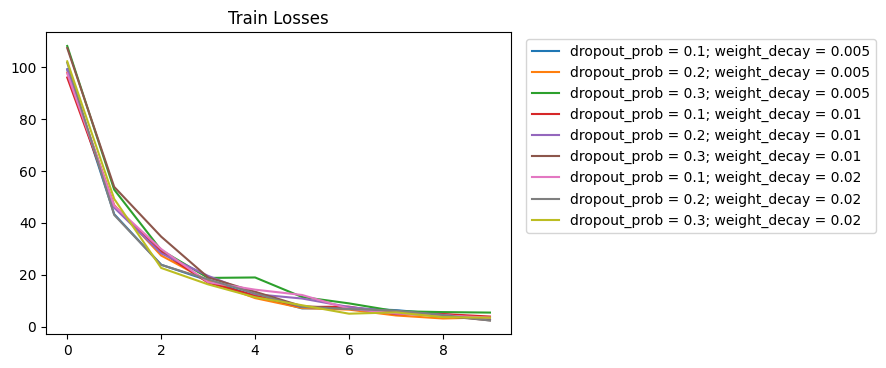

In [ ]:
plt.figure(dpi=100)
for i, dev_f1s in enumerate(all_train_losses):
    a, b = divmod(i, len(dropout_probs))
    plt.plot(dev_f1s, label=f"dropout_prob = {dropout_probs[b]}; weight_decay = {weight_decays[a]}")
plt.legend(bbox_to_anchor=(1.8, 1))
plt.title("Train Losses")
plt.show()

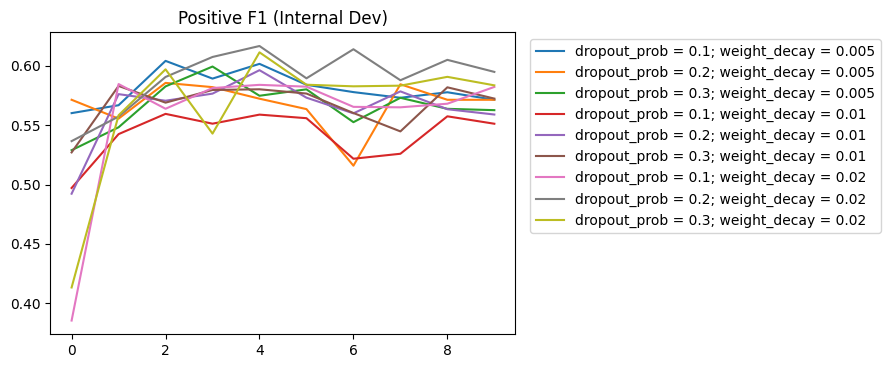

In [ ]:
plt.figure(dpi=100)
for i, dev_f1s in enumerate(all_dev_f1s):
    a, b = divmod(i, len(dropout_probs))
    plt.plot(dev_f1s, label=f"dropout_prob = {dropout_probs[b]}; weight_decay = {weight_decays[a]}")
plt.legend(bbox_to_anchor=(1.8, 1))
plt.title("Positive F1 (Internal Dev)")
plt.show()

In [ ]:
for i, dev_f1s in enumerate(all_dev_f1s):
    a, b = divmod(i, len(dropout_probs))
    print(f"dropout_prob = {dropout_probs[b]}; weight_decay = {weight_decays[a]}. Final Pos F1 (Internal Dev): {dev_f1s[-1]}")

dropout_prob = 0.1; weight_decay = 0.005. Final Pos F1 (Internal Dev): 0.5714285714285713
dropout_prob = 0.2; weight_decay = 0.005. Final Pos F1 (Internal Dev): 0.5714285714285715
dropout_prob = 0.3; weight_decay = 0.005. Final Pos F1 (Internal Dev): 0.5626911314984709
dropout_prob = 0.1; weight_decay = 0.01. Final Pos F1 (Internal Dev): 0.5512367491166077
dropout_prob = 0.2; weight_decay = 0.01. Final Pos F1 (Internal Dev): 0.5590062111801242
dropout_prob = 0.3; weight_decay = 0.01. Final Pos F1 (Internal Dev): 0.5724381625441697
dropout_prob = 0.1; weight_decay = 0.02. Final Pos F1 (Internal Dev): 0.5822784810126582
dropout_prob = 0.2; weight_decay = 0.02. Final Pos F1 (Internal Dev): 0.5949367088607594
dropout_prob = 0.3; weight_decay = 0.02. Final Pos F1 (Internal Dev): 0.583606557377049
